<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (n, n) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (n * m, n)
        m, n = X.shape
        q = compute_q(p)
        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", m, n)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", n*m)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_scale_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_scale_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        if np.sum(S_mis * S_mis) == 0:
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        elif S_mis.shape == (m, n, n):
          S_dts_tiled = np.concatenate([S_dts] * m)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (n, n):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (n * m, n):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (m, n), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_scale_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_scale_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, dts_max, mis_max, eps_amax=1e-5, eps_dts_max=1e-2, eps_mis_max=1e-1, n_alphas=100, n_deltas_dts=4, n_deltas_mis=1):
    _, m = X.shape
    amin = eps_amax * amax
    dts_min = eps_dts_max * dts_max
    mis_min = eps_mis_max * mis_max
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    dts_deltas = np.logspace(np.log10(dts_min), np.log10(dts_max), n_deltas_dts)
    mis_deltas = np.logspace(np.log10(mis_min), np.log10(mis_max), n_deltas_mis)
    print("dts deltas ", dts_deltas)
    #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
    hyper_p_ret_ = []
    coefs_ = []
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
    estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
    hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, 1e2, 1e1, 1e1)
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf

'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [34]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [35]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + 1e-2 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [60]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:  # Rubin's Rule
      if info['cov_strategy'] == 'std_mi':
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = np.diag(s_within)
        print("final S in cov strategy std_mi ", S)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure']:
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
    else:
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      X_train = np.concatenate(X_imputed)
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    #dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) * dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  * dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing}  #, 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi_pure':
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      for i in range(dict_imp['mi_nbr']):
        print("i .-------------> ", i)
        dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        S = S_within[None, :, :] + S_between
        S = np.concatenate(S, axis=0)
        #print(S)
        alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
        best_coeff_partial, best_alpha_partial = coeff_results[:, idx_best], alphas_used[idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
        best_coeff /= dict_imp['mi_nbr']
      best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha, best_delta_dts, best_delta_mis = best_hyper_p[0], best_hyper_p[1], best_hyper_p[2]
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = (S_dict['S_dts'] * best_delta_dts + S_dict['S_mis'] * best_delta_mis) * best_alpha
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha, coef_dts, coef_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])

    return best_coeff, min_score, -np.log10(best_alpha)



In [65]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed = dict_obser = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0])
      mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        #mask_partial = dict_obser_partial['X_train_masked'][1]
        p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
        n_train = mask_no_both_seen.shape[0]
        mask_partial = mask_no_both_seen.copy()
        mask_partial[0:int(n_train * p_i), :] = 0
        #mask_partial = mask_no_both_seen[0:int(n_train * p_i), :]
        tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
        dict_obser['X_train_masked'] = tuple_partial
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}}  # add an entry for imputed dataset
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio



change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
n_tot :  20100
n_train :  100
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9950248756218906
err :  {'type': 'Gaussian_on_y', 'scaling': 0.1}
plots :  []
p_miss :  [0.9, 0.04999999999999999, 0.04999999999999999]
generation :  f
title_infer_error :   
title_test_error :   
[{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}]
imp_method :  BR_si
cov_strategy :  std_nan
multip_dataset :  1
multip_missing :  1
imp_method :  oracle
cov_strategy :  sd
multip_dataset :  3
multip_missing :  0
imp_method :  oracle
cov_strategy :  sd
multip_dataset :  0
multip_missing :  0
----> Starting experiments
[[], [], []]
[]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 178.52it/s]

 38%|███▊      | 38/100 [00:00<00:00, 184.90it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 189.48it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 190.11it/s]

100%|██████████| 100/100 [00:00<00:00, 185.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 195.56it/s]

 41%|████      | 41/100 [00:00<00:00, 180.30it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 189.63it/s]

100%|██████████| 100/100 [00:00<00:00, 189.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 202.92it/s]

 42%|████▏     | 42/100 [00:00<00:00, 200.59it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 189.32it/s]

100%|██████████| 100/100 [00:00<00:00, 194.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊       

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  156  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.67341507 0.46415888 1.        ] , min score  0.021552691888176673
---------------------------------> best coeff  [-0.39449281  1.90686253]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9874573  1.00592884]
crush test------------------------------------------------->  -16.051666402274748
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.96237191 0.        ]
 [0.         3.017

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.10it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.09it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 183.28it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 182.68it/s]

100%|██████████| 100/100 [00:00<00:00, 174.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 205.32it/s]

 42%|████▏     | 42/100 [00:00<00:00, 204.70it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 194.28it/s]

100%|██████████| 100/100 [00:00<00:00, 193.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.61it/s]

 38%|███▊      | 38/100 [00:00<00:00, 188.17it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 181.48it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 172.27it/s]

100%|██████████| 100/100 [00:00<00:00, 177.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.20450354 0.1        1.        ] , min score  0.020069177064739326
---------------------------------> best coeff  [-0.4046556   1.90900118]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9874573  1.00592884]
crush test------------------------------------------------->  -16.051666402274748
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy m

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.67it/s]

 38%|███▊      | 38/100 [00:00<00:00, 189.33it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 190.06it/s]

100%|██████████| 100/100 [00:00<00:00, 200.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 221.40it/s]

 46%|████▌     | 46/100 [00:00<00:00, 220.14it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 219.77it/s]

100%|██████████| 100/100 [00:00<00:00, 217.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 216.34it/s]

 44%|████▍     | 44/100 [00:00<00:00, 214.13it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 205.37it/s]

100%|██████████| 100/100 [00:00<00:00, 212.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 219.58it/s]

 44%|████▍    

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010429785434824817
---------------------------------> best coeff  [-0.52339783  2.01241619]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9874573  1.00592884]
crush test------------------------------------------------->  -24.130853659254274
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.53it/s]

 23%|██▎       | 23/100 [00:00<00:00, 113.66it/s]

 36%|███▌      | 36/100 [00:00<00:00, 118.29it/s]

 48%|████▊     | 48/100 [00:00<00:00, 117.83it/s]

 60%|██████    | 60/100 [00:00<00:00, 117.97it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 118.64it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 120.40it/s]

100%|██████████| 100/100 [00:00<00:00, 117.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.10it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.14it/s]

 35%|███▌      | 35/100 [00:00<00:00, 112.29it/s]

 47%|████▋     | 47/100 [00:00<00:00, 114.57it/s]

 60%|██████    | 60/100 [00:00<00:00, 117.91it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 118.03it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 118.43it/s]

100%|██████████| 100/100 [00:00<00:00, 114.45it/s]

  0%|          | 0/1 [0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  327  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.0231013 10.         1.       ] , min score  0.02250876628640927
---------------------------------> best coeff  [-0.38874112  1.90525699]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9874573  1.00592884]
crush test------------------------------------------------->  -16.051666402274748
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.96237191 0.        ]
 [0.         3.0177

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.44it/s]

 33%|███▎      | 33/100 [00:00<00:00, 169.17it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 183.14it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 180.78it/s]

100%|██████████| 100/100 [00:00<00:00, 177.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.51it/s]

 41%|████      | 41/100 [00:00<00:00, 202.05it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 194.27it/s]

100%|██████████| 100/100 [00:00<00:00, 190.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.09it/s]

 40%|████      | 40/100 [00:00<00:00, 193.53it/s]

 60%|██████    | 60/100 [00:00<00:00, 186.05it/s]

 80%|████████  | 80/100 [00:00<00:00, 188.92it/s]

100%|██████████| 100/100 [00:00<00:00, 188.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.20450354 0.1        1.        ] , min score  0.020069177064739326
---------------------------------> best coeff  [-0.4046556   1.90900118]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9874573  1.00592884]
crush test------------------------------------------------->  -16.051666402274748
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy m

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.75it/s]

 38%|███▊      | 38/100 [00:00<00:00, 190.14it/s]

 60%|██████    | 60/100 [00:00<00:00, 202.98it/s]

100%|██████████| 100/100 [00:00<00:00, 202.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 216.72it/s]

 44%|████▍     | 44/100 [00:00<00:00, 214.72it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 214.81it/s]

100%|██████████| 100/100 [00:00<00:00, 208.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.31it/s]

 42%|████▏     | 42/100 [00:00<00:00, 197.83it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 201.67it/s]

100%|██████████| 100/100 [00:00<00:00, 205.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 213.40it/s]

 44%|████▍    

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010429785434824817
---------------------------------> best coeff  [-0.52339783  2.01241619]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9874573  1.00592884]
crush test------------------------------------------------->  -24.243651654498237
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.53it/s]

 37%|███▋      | 37/100 [00:00<00:00, 181.28it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 186.06it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 194.15it/s]

100%|██████████| 100/100 [00:00<00:00, 188.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.50it/s]

 41%|████      | 41/100 [00:00<00:00, 198.87it/s]

 61%|██████    | 61/100 [00:00<00:00, 188.53it/s]

100%|██████████| 100/100 [00:00<00:00, 192.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 191.73it/s]

 40%|████      | 40/100 [00:00<00:00, 191.46it/s]

 61%|██████    | 61/100 [00:00<00:00, 199.12it/s]

100%|██████████| 100/100 [00:00<00:00, 194.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██       

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  147  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.23644894 0.46415888 1.        ] , min score  0.03156411851012562
---------------------------------> best coeff  [-0.33958962  1.91337596]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9874573  1.00592884]
crush test------------------------------------------------->  -16.051666402274748
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.96237191 0.        ]
 [0.         3.0177

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.81it/s]

 37%|███▋      | 37/100 [00:00<00:00, 186.13it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 194.71it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 187.83it/s]

100%|██████████| 100/100 [00:00<00:00, 183.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.56it/s]

 37%|███▋      | 37/100 [00:00<00:00, 182.76it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 181.56it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 177.24it/s]

100%|██████████| 100/100 [00:00<00:00, 180.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.74it/s]

 40%|████      | 40/100 [00:00<00:00, 193.44it/s]

 60%|██████    | 60/100 [00:00<00:00, 189.32it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 189.36it/s]

100%|██████████| 100/100 [00:00<00:00, 183.0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.20450354 0.1        1.        ] , min score  0.020069177064739326
---------------------------------> best coeff  [-0.4046556   1.90900118]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9874573  1.00592884]
crush test------------------------------------------------->  -16.051666402274748
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy m

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.88it/s]

 34%|███▍      | 34/100 [00:00<00:00, 163.25it/s]

 51%|█████     | 51/100 [00:00<00:00, 142.66it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 132.88it/s]

 80%|████████  | 80/100 [00:00<00:00, 131.37it/s]

100%|██████████| 100/100 [00:00<00:00, 134.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.20it/s]

 27%|██▋       | 27/100 [00:00<00:00, 130.44it/s]

 41%|████      | 41/100 [00:00<00:00, 131.69it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 128.74it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 130.32it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 130.48it/s]

100%|██████████| 100/100 [00:00<00:00, 128.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.74it/s]

 25%|██▌       | 25/100 [00:00<00:00, 127.39

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010429785434824817
---------------------------------> best coeff  [-0.52339783  2.01241619]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.39449281,  1.90686253]), array([-0.38874112,  1.90525699]), array([-0.33958962,  1.91337596])], 'l2_dist_best_coeff_gt': [np.float64(0.14073505647298654), np.float64(0.14613273596342638), np.float64(0.18230528133394705)], 'best_score': [np.float64(0.021552691888176673), np.float64(0.02250876628640927), np.float64(0.03156411851012562)], 'best_alpha': [np.float64(0.1717171717171717), np.float64(1.6363636363636365), np.float64(0.6262626262626263)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.4046556 ,  1.90900118]), array([-0.4046556 ,  1.90900118]), array([-0.4046556 ,  1.90900118

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.46it/s]

 21%|██        | 21/100 [00:00<00:00, 99.38it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.43it/s]

 46%|████▌     | 46/100 [00:00<00:00, 114.22it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 110.52it/s]

 70%|███████   | 70/100 [00:00<00:00, 103.04it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 105.58it/s]

100%|██████████| 100/100 [00:00<00:00, 105.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.25it/s]

 25%|██▌       | 25/100 [00:00<00:00, 119.50it/s]

 38%|███▊      | 38/100 [00:00<00:00, 120.83it/s]

 51%|█████     | 51/100 [00:00<00:00, 116.09it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 116.59it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 110.88it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 110.07it/s]

100%|██████████| 100/100 [00:00<00:00, 111.51it/s]

  0%|          | 0/1 [00

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  243  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.14849683 2.15443469 1.        ] , min score  0.023049479004290187
---------------------------------> best coeff  [-0.40851856  1.88422225]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05762577 1.02416754]
crush test------------------------------------------------->  -23.819077250327048
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.1728773  0.        ]
 [0.         3.072

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.61it/s]

 35%|███▌      | 35/100 [00:00<00:00, 177.56it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 190.07it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 181.71it/s]

100%|██████████| 100/100 [00:00<00:00, 178.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.15it/s]

 40%|████      | 40/100 [00:00<00:00, 194.46it/s]

 60%|██████    | 60/100 [00:00<00:00, 175.01it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 174.69it/s]

100%|██████████| 100/100 [00:00<00:00, 178.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.06it/s]

 39%|███▉      | 39/100 [00:00<00:00, 188.17it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 180.06it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 179.84it/s]

100%|██████████| 100/100 [00:00<00:00, 180.0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.20450354 0.1        1.        ] , min score  0.02351790434422424
---------------------------------> best coeff  [-0.40709405  1.88210038]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05762577 1.02416754]
crush test------------------------------------------------->  -23.819077250327048
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mi

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.12it/s]

 37%|███▋      | 37/100 [00:00<00:00, 185.83it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 197.34it/s]

100%|██████████| 100/100 [00:00<00:00, 196.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.00it/s]

 39%|███▉      | 39/100 [00:00<00:00, 191.96it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 193.99it/s]

100%|██████████| 100/100 [00:00<00:00, 197.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.00it/s]

 41%|████      | 41/100 [00:00<00:00, 199.80it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 203.19it/s]

100%|██████████| 100/100 [00:00<00:00, 201.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.12it/s]

 36%|███▌     

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010163023481492638
---------------------------------> best coeff  [-0.5149854   2.00209865]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05762577 1.02416754]
crush test------------------------------------------------->  -29.995760352999714
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.45it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.70it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 178.06it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 178.85it/s]

100%|██████████| 100/100 [00:00<00:00, 175.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.28it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.47it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 180.57it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 182.96it/s]

100%|██████████| 100/100 [00:00<00:00, 181.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.98it/s]

 39%|███▉      | 39/100 [00:00<00:00, 188.89it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 180.26it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 175.98it/s]

100%|██████████| 100/100 [00:00<00:00, 177.6

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.06579332 0.1        1.        ] , min score  0.021341072642564674
---------------------------------> best coeff  [-0.60994047  2.01384361]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05762577 1.02416754]
crush test------------------------------------------------->  -23.819077250327048
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.1728773  0.        ]
 [0.         3.0725

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 120.24it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.79it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 178.28it/s]

 71%|███████   | 71/100 [00:00<00:00, 174.92it/s]

100%|██████████| 100/100 [00:00<00:00, 162.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.58it/s]

 26%|██▌       | 26/100 [00:00<00:00, 124.89it/s]

 39%|███▉      | 39/100 [00:00<00:00, 123.07it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 118.89it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 113.41it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 110.57it/s]

 88%|████████▊ | 88/100 [00:00<00:00, 108.66it/s]

100%|██████████| 100/100 [00:00<00:00, 110.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.16it/s]

 26%|██▌       | 26/100 [00:00<00:00, 125.30

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.20450354 0.1        1.        ] , min score  0.02351790434422424
---------------------------------> best coeff  [-0.40709405  1.88210038]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05762577 1.02416754]
crush test------------------------------------------------->  -23.819077250327048
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mi

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.86it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.58it/s]

 36%|███▌      | 36/100 [00:00<00:00, 120.86it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 149.00it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 165.74it/s]

100%|██████████| 100/100 [00:00<00:00, 157.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.54it/s]

 40%|████      | 40/100 [00:00<00:00, 184.30it/s]

 60%|██████    | 60/100 [00:00<00:00, 190.59it/s]

100%|██████████| 100/100 [00:00<00:00, 196.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.31it/s]

 40%|████      | 40/100 [00:00<00:00, 199.45it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 205.76it/s]

100%|██████████| 100/100 [00:00<00:00, 203.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010163023481492638
---------------------------------> best coeff  [-0.5149854   2.00209865]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05762577 1.02416754]
crush test------------------------------------------------->  -31.063215141678768
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.58it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.80it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 181.79it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 186.53it/s]

100%|██████████| 100/100 [00:00<00:00, 182.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.86it/s]

 34%|███▍      | 34/100 [00:00<00:00, 169.81it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 177.69it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 185.57it/s]

100%|██████████| 100/100 [00:00<00:00, 179.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.15it/s]

 35%|███▌      | 35/100 [00:00<00:00, 175.79it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 184.54it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 185.45it/s]

100%|██████████| 100/100 [00:00<00:00, 174.5

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  234  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.05214008 2.15443469 1.        ] , min score  0.02050920895386019
---------------------------------> best coeff  [-0.40979127  1.90078767]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05762577 1.02416754]
crush test------------------------------------------------->  -23.819077250327048
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.1728773  0.        ]
 [0.         3.0725

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.03it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.77it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 170.76it/s]

 70%|███████   | 70/100 [00:00<00:00, 170.53it/s]

100%|██████████| 100/100 [00:00<00:00, 170.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.62it/s]

 38%|███▊      | 38/100 [00:00<00:00, 188.50it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 177.13it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 174.72it/s]

100%|██████████| 100/100 [00:00<00:00, 176.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.09it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.33it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 171.54it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 173.60it/s]

100%|██████████| 100/100 [00:00<00:00, 173.3

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.20450354 0.1        1.        ] , min score  0.02351790434422424
---------------------------------> best coeff  [-0.40709405  1.88210038]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05762577 1.02416754]
crush test------------------------------------------------->  -23.819077250327048
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mi

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.56it/s]

 37%|███▋      | 37/100 [00:00<00:00, 184.95it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 197.14it/s]

100%|██████████| 100/100 [00:00<00:00, 196.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.13it/s]

 39%|███▉      | 39/100 [00:00<00:00, 188.44it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 192.10it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 185.74it/s]

100%|██████████| 100/100 [00:00<00:00, 186.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.38it/s]

 40%|████      | 40/100 [00:00<00:00, 197.64it/s]

 60%|██████    | 60/100 [00:00<00:00, 198.19it/s]

100%|██████████| 100/100 [00:00<00:00, 200.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉       

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010163023481492638
---------------------------------> best coeff  [-0.5149854   2.00209865]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.40851856,  1.88422225]), array([-0.60994047,  2.01384361]), array([-0.40979127,  1.90078767])], 'l2_dist_best_coeff_gt': [np.float64(0.14755792828053393), np.float64(0.11080863349497647), np.float64(0.1340921388294804)], 'best_score': [np.float64(0.023049479004290187), np.float64(0.021341072642564674), np.float64(0.02050920895386019)], 'best_alpha': [np.float64(0.8282828282828283), np.float64(1.1818181818181819), np.float64(1.2828282828282829)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.40709405,  1.88210038]), array([-0.40709405,  1.88210038]), array([-0.40709405,  1.88210038

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.56it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.93it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 181.68it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 180.60it/s]

100%|██████████| 100/100 [00:00<00:00, 177.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.31it/s]

 34%|███▍      | 34/100 [00:00<00:00, 131.97it/s]

 48%|████▊     | 48/100 [00:00<00:00, 126.45it/s]

 61%|██████    | 61/100 [00:00<00:00, 121.83it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 120.36it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 120.34it/s]

100%|██████████| 100/100 [00:00<00:00, 122.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.06it/s]

 24%|██▍       | 24/100 [00:00<00:00, 113.18it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.27

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  155  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.59948425 0.46415888 1.        ] , min score  0.020479293035414757
---------------------------------> best coeff  [-0.42035952  1.89498085]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01735866 1.04545579]
crush test------------------------------------------------->  31.83033959286514
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.05207599 0.        ]
 [0.         3.13636

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.63it/s]

 21%|██        | 21/100 [00:00<00:00, 104.85it/s]

 34%|███▍      | 34/100 [00:00<00:00, 113.77it/s]

 47%|████▋     | 47/100 [00:00<00:00, 117.87it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 111.18it/s]

 71%|███████   | 71/100 [00:00<00:00, 110.69it/s]

100%|██████████| 100/100 [00:00<00:00, 122.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.57it/s]

 38%|███▊      | 38/100 [00:00<00:00, 190.82it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 184.33it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 186.46it/s]

100%|██████████| 100/100 [00:00<00:00, 186.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.84it/s]

 36%|███▌      | 36/100 [00:00<00:00, 170.29it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 155.55it

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.07226722 0.1        1.        ] , min score  0.022751325254834455
---------------------------------> best coeff  [-0.40269484  1.89052777]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01735866 1.04545579]
crush test------------------------------------------------->  31.83033959286514
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mis

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.79it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.99it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 195.42it/s]

100%|██████████| 100/100 [00:00<00:00, 197.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.81it/s]

 41%|████      | 41/100 [00:00<00:00, 204.88it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 206.53it/s]

100%|██████████| 100/100 [00:00<00:00, 196.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.97it/s]

 39%|███▉      | 39/100 [00:00<00:00, 191.35it/s]

 60%|██████    | 60/100 [00:00<00:00, 198.15it/s]

100%|██████████| 100/100 [00:00<00:00, 199.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.77it/s]

 40%|████     

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010046604105681069
---------------------------------> best coeff  [-0.4846825   1.99059362]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01735866 1.04545579]
crush test------------------------------------------------->  25.979892775135646
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.55it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.95it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 180.17it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 183.64it/s]

100%|██████████| 100/100 [00:00<00:00, 182.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.07it/s]

 38%|███▊      | 38/100 [00:00<00:00, 175.03it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 170.44it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 179.19it/s]

100%|██████████| 100/100 [00:00<00:00, 179.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.87it/s]

 36%|███▌      | 36/100 [00:00<00:00, 178.16it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 184.40it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 188.35it/s]

100%|██████████| 100/100 [00:00<00:00, 185.3

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  240  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.10476158 2.15443469 1.        ] , min score  0.022481469495862796
---------------------------------> best coeff  [-0.40988405  1.8874397 ]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01735866 1.04545579]
crush test------------------------------------------------->  31.83033959286514
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.05207599 0.        ]
 [0.         3.13636

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.43it/s]

 34%|███▍      | 34/100 [00:00<00:00, 170.21it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 185.49it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 173.72it/s]

100%|██████████| 100/100 [00:00<00:00, 170.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.91it/s]

 38%|███▊      | 38/100 [00:00<00:00, 188.87it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 187.02it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 186.35it/s]

100%|██████████| 100/100 [00:00<00:00, 185.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.43it/s]

 38%|███▊      | 38/100 [00:00<00:00, 183.07it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 181.09it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 179.96it/s]

100%|██████████| 100/100 [00:00<00:00, 177.1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.07226722 0.1        1.        ] , min score  0.022751325254834455
---------------------------------> best coeff  [-0.40269484  1.89052777]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01735866 1.04545579]
crush test------------------------------------------------->  31.83033959286514
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mis

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.37it/s]

 34%|███▍      | 34/100 [00:00<00:00, 172.84it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.03it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 185.71it/s]

100%|██████████| 100/100 [00:00<00:00, 183.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.58it/s]

 41%|████      | 41/100 [00:00<00:00, 200.20it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 204.19it/s]

100%|██████████| 100/100 [00:00<00:00, 195.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.31it/s]

 26%|██▌       | 26/100 [00:00<00:00, 110.04it/s]

 39%|███▉      | 39/100 [00:00<00:00, 115.78it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 118.29it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 123.26it/s]

 80%|████████  | 80/100 [00:00<00:00, 125.86

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010046604105681069
---------------------------------> best coeff  [-0.4846825   1.99059362]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01735866 1.04545579]
crush test------------------------------------------------->  22.9192785543204
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.48it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.34it/s]

 35%|███▌      | 35/100 [00:00<00:00, 112.36it/s]

 47%|████▋     | 47/100 [00:00<00:00, 113.57it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 112.59it/s]

 71%|███████   | 71/100 [00:00<00:00, 110.29it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 113.24it/s]

100%|██████████| 100/100 [00:00<00:00, 113.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.11it/s]

 23%|██▎       | 23/100 [00:00<00:00, 110.94it/s]

 35%|███▌      | 35/100 [00:00<00:00, 112.38it/s]

 47%|████▋     | 47/100 [00:00<00:00, 113.58it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 113.48it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 124.64it/s]

100%|██████████| 100/100 [00:00<00:00, 128.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?i

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.21049041 0.1        1.        ] , min score  0.03742278407071243
---------------------------------> best coeff  [-0.64816964  1.96412324]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01735866 1.04545579]
crush test------------------------------------------------->  31.83033959286514
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.05207599 0.        ]
 [0.         3.1363673

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.19it/s]

 37%|███▋      | 37/100 [00:00<00:00, 183.03it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 190.10it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 183.96it/s]

100%|██████████| 100/100 [00:00<00:00, 182.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.52it/s]

 39%|███▉      | 39/100 [00:00<00:00, 189.66it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 164.86it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 171.82it/s]

100%|██████████| 100/100 [00:00<00:00, 175.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.53it/s]

 37%|███▋      | 37/100 [00:00<00:00, 179.41it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 177.86it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 181.52it/s]

100%|██████████| 100/100 [00:00<00:00, 180.4

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.07226722 0.1        1.        ] , min score  0.022751325254834455
---------------------------------> best coeff  [-0.40269484  1.89052777]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01735866 1.04545579]
crush test------------------------------------------------->  31.83033959286514
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mis

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.26it/s]

 37%|███▋      | 37/100 [00:00<00:00, 185.08it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 193.64it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 196.69it/s]

100%|██████████| 100/100 [00:00<00:00, 185.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.86it/s]

 36%|███▌      | 36/100 [00:00<00:00, 178.85it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 191.11it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 195.04it/s]

100%|██████████| 100/100 [00:00<00:00, 189.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.45it/s]

 38%|███▊      | 38/100 [00:00<00:00, 189.83it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 197.25it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 190.15it/s]

100%|██████████| 100/100 [00:00<00:00, 189.1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010046604105681069
---------------------------------> best coeff  [-0.4846825   1.99059362]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.42035952,  1.89498085]), array([-0.40988405,  1.8874397 ]), array([-0.64816964,  1.96412324])], 'l2_dist_best_coeff_gt': [np.float64(0.1318014699965961), np.float64(0.14418982691751475), np.float64(0.15245125542185017)], 'best_score': [np.float64(0.020479293035414757), np.float64(0.022481469495862796), np.float64(0.03742278407071243)], 'best_alpha': [np.float64(0.22222222222222227), np.float64(0.9797979797979797), np.float64(0.6767676767676769)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.40269484,  1.89052777]), array([-0.40269484,  1.89052777]), array([-0.40269484,  1.8905277

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.03it/s]

 31%|███       | 31/100 [00:00<00:00, 153.96it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.62it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 171.44it/s]

100%|██████████| 100/100 [00:00<00:00, 167.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.06it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.97it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 174.53it/s]

 71%|███████   | 71/100 [00:00<00:00, 174.50it/s]

100%|██████████| 100/100 [00:00<00:00, 169.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.80it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.04it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 178.10it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 176.92it/s]

100%|██████████| 100/100 [00:00<00:00, 176.0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  155  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.59948425 0.46415888 1.        ] , min score  0.021504390243422006
---------------------------------> best coeff  [-0.40271782  1.90077512]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9226018  0.95732577]
crush test------------------------------------------------->  24.537110577520394
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.76780541 0.        ]
 [0.         2.8719

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.03it/s]

 34%|███▍      | 34/100 [00:00<00:00, 169.32it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 179.96it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 177.83it/s]

100%|██████████| 100/100 [00:00<00:00, 172.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.81it/s]

 32%|███▏      | 32/100 [00:00<00:00, 163.58it/s]

 51%|█████     | 51/100 [00:00<00:00, 172.20it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 170.60it/s]

100%|██████████| 100/100 [00:00<00:00, 154.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.33it/s]

 24%|██▍       | 24/100 [00:00<00:00, 115.10it/s]

 36%|███▌      | 36/100 [00:00<00:00, 113.41it/s]

 48%|████▊     | 48/100 [00:00<00:00, 103.83it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 103.44

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.07226722 0.1        1.        ] , min score  0.02067877876778339
---------------------------------> best coeff  [-0.40817134  1.90260784]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9226018  0.95732577]
crush test------------------------------------------------->  24.537110577520394
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mis

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 76.70it/s]

 20%|██        | 20/100 [00:00<00:00, 101.50it/s]

 34%|███▍      | 34/100 [00:00<00:00, 115.45it/s]

 47%|████▋     | 47/100 [00:00<00:00, 117.81it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 115.15it/s]

 71%|███████   | 71/100 [00:00<00:00, 109.48it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 113.85it/s]

100%|██████████| 100/100 [00:00<00:00, 113.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.88it/s]

 25%|██▌       | 25/100 [00:00<00:00, 119.28it/s]

 38%|███▊      | 38/100 [00:00<00:00, 123.64it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 145.42it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 165.89it/s]

100%|██████████| 100/100 [00:00<00:00, 156.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 148.94it

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.0100661599385774
---------------------------------> best coeff  [-0.51281463  2.00202094]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9226018  0.95732577]
crush test------------------------------------------------->  24.788407624049363
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.28it/s]

 34%|███▍      | 34/100 [00:00<00:00, 169.50it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 176.49it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 179.23it/s]

100%|██████████| 100/100 [00:00<00:00, 177.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.54it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.19it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 176.90it/s]

 71%|███████   | 71/100 [00:00<00:00, 169.87it/s]

100%|██████████| 100/100 [00:00<00:00, 168.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.82it/s]

 36%|███▌      | 36/100 [00:00<00:00, 179.71it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 178.96it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 175.18it/s]

100%|██████████| 100/100 [00:00<00:00, 174.5

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  67  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826 0.1        1.        ] , min score  0.023963895150252518
---------------------------------> best coeff  [-0.41314559  1.8774888 ]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9226018  0.95732577]
crush test------------------------------------------------->  24.537110577520394
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.76780541 0.        ]
 [0.         2.87197

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.52it/s]

 34%|███▍      | 34/100 [00:00<00:00, 171.85it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 178.39it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 161.75it/s]

100%|██████████| 100/100 [00:00<00:00, 160.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.22it/s]

 38%|███▊      | 38/100 [00:00<00:00, 188.60it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 180.96it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 178.18it/s]

100%|██████████| 100/100 [00:00<00:00, 177.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.14it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.13it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 163.20it/s]

 71%|███████   | 71/100 [00:00<00:00, 160.55it/s]

100%|██████████| 100/100 [00:00<00:00, 166.3

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.07226722 0.1        1.        ] , min score  0.02067877876778339
---------------------------------> best coeff  [-0.40817134  1.90260784]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9226018  0.95732577]
crush test------------------------------------------------->  24.537110577520394
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mis

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.90it/s]

 31%|███       | 31/100 [00:00<00:00, 161.56it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 184.76it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 192.80it/s]

100%|██████████| 100/100 [00:00<00:00, 183.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.76it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.81it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 194.17it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 195.28it/s]

100%|██████████| 100/100 [00:00<00:00, 188.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.52it/s]

 36%|███▌      | 36/100 [00:00<00:00, 178.17it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 187.17it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 193.49it/s]

100%|██████████| 100/100 [00:00<00:00, 186.7

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.0100661599385774
---------------------------------> best coeff  [-0.51281463  2.00202094]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9226018  0.95732577]
crush test------------------------------------------------->  20.948588325225916
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.00it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.23it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 175.50it/s]

 70%|███████   | 70/100 [00:00<00:00, 174.53it/s]

100%|██████████| 100/100 [00:00<00:00, 173.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.93it/s]

 35%|███▌      | 35/100 [00:00<00:00, 171.51it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 165.20it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 175.72it/s]

100%|██████████| 100/100 [00:00<00:00, 160.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.04it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.15it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.03it/s]

 46%|████▌     | 46/100 [00:00<00:00, 112.14it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 116.18

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  150  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.33516027 0.46415888 1.        ] , min score  0.026365558723248556
---------------------------------> best coeff  [-0.41158055  1.8653052 ]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9226018  0.95732577]
crush test------------------------------------------------->  24.537110577520394
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.76780541 0.        ]
 [0.         2.8719

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.90it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.24it/s]

 35%|███▌      | 35/100 [00:00<00:00, 112.06it/s]

 47%|████▋     | 47/100 [00:00<00:00, 114.82it/s]

 60%|██████    | 60/100 [00:00<00:00, 118.51it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 115.05it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 107.05it/s]

100%|██████████| 100/100 [00:00<00:00, 110.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.02it/s]

 24%|██▍       | 24/100 [00:00<00:00, 104.88it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.00it/s]

 48%|████▊     | 48/100 [00:00<00:00, 112.86it/s]

 60%|██████    | 60/100 [00:00<00:00, 106.52it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 119.60it/s]

100%|██████████| 100/100 [00:00<00:00, 125.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?i

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.07226722 0.1        1.        ] , min score  0.02067877876778339
---------------------------------> best coeff  [-0.40817134  1.90260784]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9226018  0.95732577]
crush test------------------------------------------------->  24.537110577520394
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mis

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.52it/s]

 30%|███       | 30/100 [00:00<00:00, 156.60it/s]

 48%|████▊     | 48/100 [00:00<00:00, 164.32it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 177.06it/s]

100%|██████████| 100/100 [00:00<00:00, 176.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.62it/s]

 37%|███▋      | 37/100 [00:00<00:00, 187.42it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 197.24it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 195.52it/s]

100%|██████████| 100/100 [00:00<00:00, 181.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.20it/s]

 35%|███▌      | 35/100 [00:00<00:00, 173.77it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 185.00it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 191.33it/s]

100%|██████████| 100/100 [00:00<00:00, 185.67

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.0100661599385774
---------------------------------> best coeff  [-0.51281463  2.00202094]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.40271782,  1.90077512]), array([-0.41314559,  1.8774888 ]), array([-0.41158055,  1.8653052 ])], 'l2_dist_best_coeff_gt': [np.float64(0.138958266745614), np.float64(0.15017550736522509), np.float64(0.16112321296076507)], 'best_score': [np.float64(0.021504390243422006), np.float64(0.023963895150252518), np.float64(0.026365558723248556)], 'best_alpha': [np.float64(0.22222222222222227), np.float64(-0.3838383838383837), np.float64(0.4747474747474749)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.40817134,  1.90260784]), array([-0.40817134,  1.90260784]), array([-0.40817134,  1.90260784

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.25it/s]

 35%|███▌      | 35/100 [00:00<00:00, 175.05it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 180.80it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 181.72it/s]

100%|██████████| 100/100 [00:00<00:00, 176.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.10it/s]

 31%|███       | 31/100 [00:00<00:00, 152.86it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.35it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 176.07it/s]

100%|██████████| 100/100 [00:00<00:00, 169.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.57it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.39it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 179.15it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 170.94it/s]

100%|██████████| 100/100 [00:00<00:00, 166.7

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  71  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.85352859 0.1        1.        ] , min score  0.023881508383643658
---------------------------------> best coeff  [-0.38595666  1.90364527]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91819625 0.91587486]
crush test------------------------------------------------->  -8.156540655959349
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.75458876 0.        ]
 [0.         2.74762

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.50it/s]

 35%|███▌      | 35/100 [00:00<00:00, 173.19it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 167.76it/s]

 71%|███████   | 71/100 [00:00<00:00, 171.14it/s]

100%|██████████| 100/100 [00:00<00:00, 168.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.68it/s]

 35%|███▌      | 35/100 [00:00<00:00, 176.75it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 178.35it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 173.71it/s]

100%|██████████| 100/100 [00:00<00:00, 170.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.31it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.44it/s]

 50%|█████     | 50/100 [00:00<00:00, 164.02it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 165.40it/s]

100%|██████████| 100/100 [00:00<00:00, 163.7

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  63  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108 0.1        1.        ] , min score  0.023105280643231658
---------------------------------> best coeff  [-0.38369378  1.91631052]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91819625 0.91587486]
crush test------------------------------------------------->  -8.156540655959349
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mi

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.04it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.73it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 176.64it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 184.30it/s]

100%|██████████| 100/100 [00:00<00:00, 180.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.72it/s]

 36%|███▌      | 36/100 [00:00<00:00, 165.40it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 140.76it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 134.00it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 126.51it/s]

100%|██████████| 100/100 [00:00<00:00, 132.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.96it/s]

 23%|██▎       | 23/100 [00:00<00:00, 113.48it/s]

 36%|███▌      | 36/100 [00:00<00:00, 117.78it/s]

 50%|█████     | 50/100 [00:00<00:00, 123.03

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010211840703040626
---------------------------------> best coeff  [-0.49203167  2.00479401]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91819625 0.91587486]
crush test------------------------------------------------->  -20.478297253184213
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 76.88it/s]

 20%|██        | 20/100 [00:00<00:00, 101.05it/s]

 32%|███▏      | 32/100 [00:00<00:00, 107.28it/s]

 43%|████▎     | 43/100 [00:00<00:00, 108.31it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 110.39it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 108.49it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 111.36it/s]

100%|██████████| 100/100 [00:00<00:00, 105.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 120.46it/s]

 26%|██▌       | 26/100 [00:00<00:00, 116.79it/s]

 39%|███▉      | 39/100 [00:00<00:00, 121.36it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 141.60it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 155.59it/s]

100%|██████████| 100/100 [00:00<00:00, 148.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.84it

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  329  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.02915053 10.          1.        ] , min score  0.020793689976212004
---------------------------------> best coeff  [-0.40341407  1.91030139]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91819625 0.91587486]
crush test------------------------------------------------->  -8.156540655959349
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.75458876 0.        ]
 [0.         2.7

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.63it/s]

 32%|███▏      | 32/100 [00:00<00:00, 161.78it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 175.18it/s]

 70%|███████   | 70/100 [00:00<00:00, 171.36it/s]

100%|██████████| 100/100 [00:00<00:00, 163.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.97it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.24it/s]

 51%|█████     | 51/100 [00:00<00:00, 161.44it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 161.78it/s]

100%|██████████| 100/100 [00:00<00:00, 162.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.97it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.77it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.09it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 165.75it/s]

100%|██████████| 100/100 [00:00<00:00, 164.8

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  63  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108 0.1        1.        ] , min score  0.023105280643231658
---------------------------------> best coeff  [-0.38369378  1.91631052]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91819625 0.91587486]
crush test------------------------------------------------->  -8.156540655959349
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mi

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.27it/s]

 32%|███▏      | 32/100 [00:00<00:00, 164.57it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 179.04it/s]

 70%|███████   | 70/100 [00:00<00:00, 171.74it/s]

100%|██████████| 100/100 [00:00<00:00, 176.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.89it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.64it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 178.71it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 186.70it/s]

100%|██████████| 100/100 [00:00<00:00, 181.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.36it/s]

 35%|███▌      | 35/100 [00:00<00:00, 176.35it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 172.84it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 180.70it/s]

100%|██████████| 100/100 [00:00<00:00, 178.7

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010211840703040626
---------------------------------> best coeff  [-0.49203167  2.00479401]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91819625 0.91587486]
crush test------------------------------------------------->  -21.19746326513671
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.55it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.77it/s]

 46%|████▌     | 46/100 [00:00<00:00, 155.29it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 164.73it/s]

 81%|████████  | 81/100 [00:00<00:00, 154.78it/s]

100%|██████████| 100/100 [00:00<00:00, 154.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.00it/s]

 32%|███▏      | 32/100 [00:00<00:00, 156.67it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.85it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 163.35it/s]

100%|██████████| 100/100 [00:00<00:00, 163.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.63it/s]

 31%|███       | 31/100 [00:00<00:00, 156.43it/s]

 50%|█████     | 50/100 [00:00<00:00, 171.29it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 174.69

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  324  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01629751 10.          1.        ] , min score  0.021421430385816783
---------------------------------> best coeff  [-0.4212328   1.89202023]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91819625 0.91587486]
crush test------------------------------------------------->  -8.156540655959349
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.75458876 0.        ]
 [0.         2.7

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.97it/s]

 32%|███▏      | 32/100 [00:00<00:00, 163.66it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 177.34it/s]

 70%|███████   | 70/100 [00:00<00:00, 170.94it/s]

100%|██████████| 100/100 [00:00<00:00, 153.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.39it/s]

 24%|██▍       | 24/100 [00:00<00:00, 117.19it/s]

 37%|███▋      | 37/100 [00:00<00:00, 121.59it/s]

 50%|█████     | 50/100 [00:00<00:00, 117.21it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 109.06it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 106.10it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 105.68it/s]

100%|██████████| 100/100 [00:00<00:00, 108.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.32it/s]

 25%|██▌       | 25/100 [00:00<00:00, 117.40

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  63  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108 0.1        1.        ] , min score  0.023105280643231658
---------------------------------> best coeff  [-0.38369378  1.91631052]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91819625 0.91587486]
crush test------------------------------------------------->  -8.156540655959349
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy mi

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 69.82it/s]

 17%|█▋        | 17/100 [00:00<00:00, 85.18it/s]

 28%|██▊       | 28/100 [00:00<00:00, 93.19it/s]

 41%|████      | 41/100 [00:00<00:00, 106.49it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 116.04it/s]

 70%|███████   | 70/100 [00:00<00:00, 126.75it/s]

100%|██████████| 100/100 [00:00<00:00, 129.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.19it/s]

 35%|███▌      | 35/100 [00:00<00:00, 175.38it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 187.66it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 190.70it/s]

100%|██████████| 100/100 [00:00<00:00, 181.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.19it/s]

 34%|███▍      | 34/100 [00:00<00:00, 172.30it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 185.13it/s

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010211840703040626
---------------------------------> best coeff  [-0.49203167  2.00479401]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.38595666,  1.90364527]), array([-0.40341407,  1.91030139]), array([-0.4212328 ,  1.89202023])], 'l2_dist_best_coeff_gt': [np.float64(0.1492987474024578), np.float64(0.13181306242522145), np.float64(0.13365591062828336)], 'best_score': [np.float64(0.023881508383643658), np.float64(0.020793689976212004), np.float64(0.021421430385816783)], 'best_alpha': [np.float64(-0.5858585858585856), np.float64(1.5353535353535355), np.float64(1.7878787878787878)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.38369378,  1.91631052]), array([-0.38369378,  1.91631052]), array([-0.38369378,  1.916310

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.46it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.69it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 175.22it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 179.28it/s]

100%|██████████| 100/100 [00:00<00:00, 168.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.76it/s]

 33%|███▎      | 33/100 [00:00<00:00, 165.63it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.96it/s]

 70%|███████   | 70/100 [00:00<00:00, 175.19it/s]

100%|██████████| 100/100 [00:00<00:00, 167.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.47it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.78it/s]

 51%|█████     | 51/100 [00:00<00:00, 164.22it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 167.83it/s]

100%|██████████| 100/100 [00:00<00:00, 166.0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  70  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.43046929 0.1        1.        ] , min score  0.022179642633250604
---------------------------------> best coeff  [-0.39358579  1.9078191 ]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06346653 0.95782215]
crush test------------------------------------------------->  -15.323010107290116
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.19039958 0.        ]
 [0.         2.8734

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.22it/s]

 30%|███       | 30/100 [00:00<00:00, 155.03it/s]

 48%|████▊     | 48/100 [00:00<00:00, 165.97it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 165.11it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 162.23it/s]

100%|██████████| 100/100 [00:00<00:00, 158.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.89it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.62it/s]

 51%|█████     | 51/100 [00:00<00:00, 169.17it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 157.03it/s]

100%|██████████| 100/100 [00:00<00:00, 161.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.72it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.60it/s]

 50%|█████     | 50/100 [00:00<00:00, 160.03it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 160.07

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  321  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01149757 10.          1.        ] , min score  0.020297775255765753
---------------------------------> best coeff  [-0.39981647  1.9188676 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06346653 0.95782215]
crush test------------------------------------------------->  -15.323010107290116
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strate

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.50it/s]

 31%|███       | 31/100 [00:00<00:00, 155.47it/s]

 51%|█████     | 51/100 [00:00<00:00, 172.81it/s]

 70%|███████   | 70/100 [00:00<00:00, 177.58it/s]

100%|██████████| 100/100 [00:00<00:00, 169.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.54it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.23it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.95it/s]

 71%|███████   | 71/100 [00:00<00:00, 178.02it/s]

100%|██████████| 100/100 [00:00<00:00, 174.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.06it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.76it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 166.76it/s]

 71%|███████   | 71/100 [00:00<00:00, 174.70it/s]

100%|██████████| 100/100 [00:00<00:00, 172.9

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010421695262338368
---------------------------------> best coeff  [-0.48301709  2.00770544]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06346653 0.95782215]
crush test------------------------------------------------->  -8.458559689011574
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 66.95it/s]

 19%|█▉        | 19/100 [00:00<00:00, 95.37it/s]

 31%|███       | 31/100 [00:00<00:00, 104.71it/s]

 44%|████▍     | 44/100 [00:00<00:00, 111.46it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 113.61it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 116.65it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 118.76it/s]

100%|██████████| 100/100 [00:00<00:00, 112.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.62it/s]

 26%|██▌       | 26/100 [00:00<00:00, 122.74it/s]

 39%|███▉      | 39/100 [00:00<00:00, 111.29it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 114.89it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 116.99it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 115.21it/s]

100%|██████████| 100/100 [00:00<00:00, 115.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  328  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.02595024 10.          1.        ] , min score  0.02103240321933141
---------------------------------> best coeff  [-0.40926253  1.90103311]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06346653 0.95782215]
crush test------------------------------------------------->  -15.323010107290116
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.19039958 0.        ]
 [0.         2.8

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.58it/s]

 28%|██▊       | 28/100 [00:00<00:00, 141.11it/s]

 47%|████▋     | 47/100 [00:00<00:00, 162.35it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 168.86it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 166.18it/s]

100%|██████████| 100/100 [00:00<00:00, 156.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.54it/s]

 31%|███       | 31/100 [00:00<00:00, 160.28it/s]

 49%|████▉     | 49/100 [00:00<00:00, 168.92it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 166.37it/s]

100%|██████████| 100/100 [00:00<00:00, 166.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.51it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.43it/s]

 50%|█████     | 50/100 [00:00<00:00, 161.55it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 154.49

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  321  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01149757 10.          1.        ] , min score  0.020297775255765753
---------------------------------> best coeff  [-0.39981647  1.9188676 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06346653 0.95782215]
crush test------------------------------------------------->  -15.323010107290116
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strate

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.44it/s]

 31%|███       | 31/100 [00:00<00:00, 158.59it/s]

 50%|█████     | 50/100 [00:00<00:00, 169.93it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 170.99it/s]

100%|██████████| 100/100 [00:00<00:00, 168.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.95it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.69it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 177.53it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 182.17it/s]

100%|██████████| 100/100 [00:00<00:00, 174.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.78it/s]

 33%|███▎      | 33/100 [00:00<00:00, 165.85it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 180.03it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 185.84it/s]

100%|██████████| 100/100 [00:00<00:00, 180.6

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010421695262338368
---------------------------------> best coeff  [-0.48301709  2.00770544]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06346653 0.95782215]
crush test------------------------------------------------->  -14.01066958826621
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.64it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.29it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 174.14it/s]

 71%|███████   | 71/100 [00:00<00:00, 168.27it/s]

100%|██████████| 100/100 [00:00<00:00, 171.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.82it/s]

 29%|██▉       | 29/100 [00:00<00:00, 148.31it/s]

 47%|████▋     | 47/100 [00:00<00:00, 162.41it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 170.74it/s]

100%|██████████| 100/100 [00:00<00:00, 165.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.97it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.37it/s]

 51%|█████     | 51/100 [00:00<00:00, 173.36it/s]

 70%|███████   | 70/100 [00:00<00:00, 177.63it/s]

100%|██████████| 100/100 [00:00<00:00, 167.0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  319  best hyperp [best_alpha, coef_dts, coef_mis]:  [9.11162756e-03 1.00000000e+01 1.00000000e+00] , min score  0.04577804052863331
---------------------------------> best coeff  [-0.63320292  1.91052912]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06346653 0.95782215]
crush test------------------------------------------------->  -15.323010107290116
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.19039958 0.        ]
 [0.   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.85it/s]

 30%|███       | 30/100 [00:00<00:00, 147.87it/s]

 49%|████▉     | 49/100 [00:00<00:00, 164.72it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 170.37it/s]

100%|██████████| 100/100 [00:00<00:00, 158.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.06it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.63it/s]

 50%|█████     | 50/100 [00:00<00:00, 163.61it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 163.02it/s]

100%|██████████| 100/100 [00:00<00:00, 160.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.74it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.74it/s]

 49%|████▉     | 49/100 [00:00<00:00, 159.97it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 162.86it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 164.53

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  321  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01149757 10.          1.        ] , min score  0.020297775255765753
---------------------------------> best coeff  [-0.39981647  1.9188676 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06346653 0.95782215]
crush test------------------------------------------------->  -15.323010107290116
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strate

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 78.94it/s]

 21%|██        | 21/100 [00:00<00:00, 108.55it/s]

 34%|███▍      | 34/100 [00:00<00:00, 117.16it/s]

 46%|████▌     | 46/100 [00:00<00:00, 117.01it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 112.90it/s]

 71%|███████   | 71/100 [00:00<00:00, 116.17it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 121.45it/s]

100%|██████████| 100/100 [00:00<00:00, 117.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.87it/s]

 26%|██▌       | 26/100 [00:00<00:00, 117.52it/s]

 39%|███▉      | 39/100 [00:00<00:00, 121.03it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 126.22it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 128.66it/s]

 80%|████████  | 80/100 [00:00<00:00, 121.16it/s]

100%|██████████| 100/100 [00:00<00:00, 122.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010421695262338368
---------------------------------> best coeff  [-0.48301709  2.00770544]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.39358579,  1.9078191 ]), array([-0.40926253,  1.90103311]), array([-0.63320292,  1.91052912])], 'l2_dist_best_coeff_gt': [np.float64(0.14078814617623772), np.float64(0.13426739113289185), np.float64(0.160462004539565)], 'best_score': [np.float64(0.022179642633250604), np.float64(0.02103240321933141), np.float64(0.04577804052863331)], 'best_alpha': [np.float64(-0.5353535353535355), np.float64(1.5858585858585859), np.float64(2.0404040404040407)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.39981647,  1.9188676 ]), array([-0.39981647,  1.9188676 ]), array([-0.39981647,  1.9188676 ]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.26it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.83it/s]

 51%|█████     | 51/100 [00:00<00:00, 171.06it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 172.51it/s]

100%|██████████| 100/100 [00:00<00:00, 166.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.60it/s]

 31%|███       | 31/100 [00:00<00:00, 155.15it/s]

 48%|████▊     | 48/100 [00:00<00:00, 159.64it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 157.32it/s]

 81%|████████  | 81/100 [00:00<00:00, 159.54it/s]

100%|██████████| 100/100 [00:00<00:00, 160.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.54it/s]

 31%|███       | 31/100 [00:00<00:00, 156.99it/s]

 48%|████▊     | 48/100 [00:00<00:00, 161.41it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 168.61

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.15443469 0.1        1.        ] , min score  0.021334828349716072
---------------------------------> best coeff  [-0.40253093  1.90545956]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.10649278 0.96707678]
crush test------------------------------------------------->  3.4551771564741145
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.31947835 0.        ]
 [0.         2.90123

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.76it/s]

 29%|██▉       | 29/100 [00:00<00:00, 148.16it/s]

 48%|████▊     | 48/100 [00:00<00:00, 164.84it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 167.49it/s]

100%|██████████| 100/100 [00:00<00:00, 159.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.39it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.79it/s]

 51%|█████     | 51/100 [00:00<00:00, 169.53it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 165.95it/s]

100%|██████████| 100/100 [00:00<00:00, 163.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.45it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.12it/s]

 51%|█████     | 51/100 [00:00<00:00, 148.95it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 158.69it/s]

100%|██████████| 100/100 [00:00<00:00, 161.7

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  320  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01023531 10.          1.        ] , min score  0.0211334082134909
---------------------------------> best coeff  [-0.40377583  1.90591269]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.10649278 0.96707678]
crush test------------------------------------------------->  3.4551771564741145
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.26it/s]

 37%|███▋      | 37/100 [00:00<00:00, 183.99it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 191.98it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 192.84it/s]

100%|██████████| 100/100 [00:00<00:00, 186.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.74it/s]

 34%|███▍      | 34/100 [00:00<00:00, 170.89it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 180.48it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 175.51it/s]

100%|██████████| 100/100 [00:00<00:00, 174.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.09it/s]

 37%|███▋      | 37/100 [00:00<00:00, 184.00it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 182.25it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 183.12it/s]

100%|██████████| 100/100 [00:00<00:00, 181.1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.009996430743360502
---------------------------------> best coeff  [-0.49438521  2.00347351]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.10649278 0.96707678]
crush test------------------------------------------------->  3.733792839239709
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.68it/s]

 30%|███       | 30/100 [00:00<00:00, 150.70it/s]

 48%|████▊     | 48/100 [00:00<00:00, 163.65it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 170.03it/s]

100%|██████████| 100/100 [00:00<00:00, 164.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.07it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.04it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.84it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 171.06it/s]

100%|██████████| 100/100 [00:00<00:00, 167.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.91it/s]

 31%|███       | 31/100 [00:00<00:00, 154.00it/s]

 49%|████▉     | 49/100 [00:00<00:00, 164.70it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 156.20it/s]

100%|██████████| 100/100 [00:00<00:00, 163.6

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  150  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.33516027 0.46415888 1.        ] , min score  0.021030016937964434
---------------------------------> best coeff  [-0.40297774  1.90768946]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.10649278 0.96707678]
crush test------------------------------------------------->  3.4551771564741145
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.31947835 0.        ]
 [0.         2.9012

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 64.71it/s]

 19%|█▉        | 19/100 [00:00<00:00, 94.50it/s]

 32%|███▏      | 32/100 [00:00<00:00, 106.31it/s]

 45%|████▌     | 45/100 [00:00<00:00, 113.73it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 110.68it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 105.56it/s]

 80%|████████  | 80/100 [00:00<00:00, 105.53it/s]

100%|██████████| 100/100 [00:00<00:00, 105.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.90it/s]

 24%|██▍       | 24/100 [00:00<00:00, 105.21it/s]

 36%|███▌      | 36/100 [00:00<00:00, 109.38it/s]

 48%|████▊     | 48/100 [00:00<00:00, 112.71it/s]

 60%|██████    | 60/100 [00:00<00:00, 105.66it/s]

 71%|███████   | 71/100 [00:00<00:00, 106.83it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 109.90it/s]

100%|██████████| 100/100 [00:00<00:00, 107.10it/s]

  0%|          | 0/1 [00:

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  320  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01023531 10.          1.        ] , min score  0.0211334082134909
---------------------------------> best coeff  [-0.40377583  1.90591269]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.10649278 0.96707678]
crush test------------------------------------------------->  3.4551771564741145
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.53it/s]

 34%|███▍      | 34/100 [00:00<00:00, 172.75it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 185.62it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 178.11it/s]

100%|██████████| 100/100 [00:00<00:00, 175.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.00it/s]

 32%|███▏      | 32/100 [00:00<00:00, 161.92it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 176.76it/s]

 71%|███████   | 71/100 [00:00<00:00, 181.24it/s]

100%|██████████| 100/100 [00:00<00:00, 177.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.10it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.50it/s]

 50%|█████     | 50/100 [00:00<00:00, 158.43it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 165.83it/s]

100%|██████████| 100/100 [00:00<00:00, 168.8

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.009996430743360502
---------------------------------> best coeff  [-0.49438521  2.00347351]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.10649278 0.96707678]
crush test------------------------------------------------->  8.968922581155914
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.47it/s]

 31%|███       | 31/100 [00:00<00:00, 153.84it/s]

 49%|████▉     | 49/100 [00:00<00:00, 162.82it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 163.80it/s]

100%|██████████| 100/100 [00:00<00:00, 166.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.50it/s]

 31%|███       | 31/100 [00:00<00:00, 152.02it/s]

 50%|█████     | 50/100 [00:00<00:00, 165.95it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 161.18it/s]

100%|██████████| 100/100 [00:00<00:00, 164.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.76it/s]

 31%|███       | 31/100 [00:00<00:00, 151.67it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.00it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 175.22it/s]

100%|██████████| 100/100 [00:00<00:00, 170.3

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  143  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.14849683 0.46415888 1.        ] , min score  0.02173267619639037
---------------------------------> best coeff  [-0.39469137  1.91147285]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.10649278 0.96707678]
crush test------------------------------------------------->  3.4551771564741145
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.31947835 0.        ]
 [0.         2.90123

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.88it/s]

 31%|███       | 31/100 [00:00<00:00, 158.01it/s]

 48%|████▊     | 48/100 [00:00<00:00, 161.96it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 168.32it/s]

100%|██████████| 100/100 [00:00<00:00, 160.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.32it/s]

 32%|███▏      | 32/100 [00:00<00:00, 161.25it/s]

 50%|█████     | 50/100 [00:00<00:00, 168.43it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 165.13it/s]

100%|██████████| 100/100 [00:00<00:00, 165.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.19it/s]

 31%|███       | 31/100 [00:00<00:00, 156.32it/s]

 47%|████▋     | 47/100 [00:00<00:00, 143.64it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 151.47it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 160.77

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  320  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01023531 10.          1.        ] , min score  0.0211334082134909
---------------------------------> best coeff  [-0.40377583  1.90591269]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.10649278 0.96707678]
crush test------------------------------------------------->  3.4551771564741145
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.27it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.95it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 185.26it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 191.41it/s]

100%|██████████| 100/100 [00:00<00:00, 180.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.97it/s]

 34%|███▍      | 34/100 [00:00<00:00, 170.91it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 165.24it/s]

 70%|███████   | 70/100 [00:00<00:00, 169.00it/s]

100%|██████████| 100/100 [00:00<00:00, 171.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.50it/s]

 31%|███       | 31/100 [00:00<00:00, 150.64it/s]

 47%|████▋     | 47/100 [00:00<00:00, 135.44it/s]

 61%|██████    | 61/100 [00:00<00:00, 121.72it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 118.84

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.009996430743360502
---------------------------------> best coeff  [-0.49438521  2.00347351]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.40253093,  1.90545956]), array([-0.40297774,  1.90768946]), array([-0.39469137,  1.91147285])], 'l2_dist_best_coeff_gt': [np.float64(0.135787018770687), np.float64(0.13391995751021926), np.float64(0.13757530412115312)], 'best_score': [np.float64(0.021334828349716072), np.float64(0.021030016937964434), np.float64(0.02173267619639037)], 'best_alpha': [np.float64(-0.3333333333333334), np.float64(0.4747474747474749), np.float64(0.8282828282828283)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.40377583,  1.90591269]), array([-0.40377583,  1.90591269]), array([-0.40377583,  1.90591269

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.93it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.31it/s]

 35%|███▌      | 35/100 [00:00<00:01, 34.86it/s] 

 45%|████▌     | 45/100 [00:00<00:01, 45.19it/s]

 57%|█████▋    | 57/100 [00:01<00:00, 58.50it/s]

 69%|██████▉   | 69/100 [00:01<00:00, 70.46it/s]

 80%|████████  | 80/100 [00:01<00:00, 78.41it/s]

100%|██████████| 100/100 [00:01<00:00, 68.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.64it/s]

 20%|██        | 20/100 [00:00<00:00, 98.64it/s]

 31%|███       | 31/100 [00:00<00:00, 100.55it/s]

 47%|████▋     | 47/100 [00:00<00:00, 122.45it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 131.50it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 143.25it/s]

100%|██████████| 100/100 [00:00<00:00, 133.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]



X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  70  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.43046929 0.1        1.        ] , min score  0.021556655625442265
---------------------------------> best coeff  [-0.39628589  1.90704437]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94371817 0.88915936]
crush test------------------------------------------------->  17.937830201317865
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.83115451 0.        ]
 [0.         2.66747

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.47it/s]

 31%|███       | 31/100 [00:00<00:00, 153.37it/s]

 49%|████▉     | 49/100 [00:00<00:00, 164.28it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 158.07it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 158.54it/s]

100%|██████████| 100/100 [00:00<00:00, 156.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.58it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.19it/s]

 48%|████▊     | 48/100 [00:00<00:00, 160.66it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 152.12it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 155.79it/s]

100%|██████████| 100/100 [00:00<00:00, 152.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.98it/s]

 25%|██▌       | 25/100 [00:00<00:00, 121.60it/s]

 41%|████      | 41/100 [00:00<00:00, 137.42

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  322  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.0129155 10.         1.       ] , min score  0.021504219215607908
---------------------------------> best coeff  [-0.39718582  1.90642317]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94371817 0.88915936]
crush test------------------------------------------------->  17.937830201317865
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy m

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.64it/s]

 31%|███       | 31/100 [00:00<00:00, 155.28it/s]

 50%|█████     | 50/100 [00:00<00:00, 168.64it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 175.78it/s]

100%|██████████| 100/100 [00:00<00:00, 171.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.37it/s]

 27%|██▋       | 27/100 [00:00<00:00, 134.01it/s]

 46%|████▌     | 46/100 [00:00<00:00, 156.45it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 165.49it/s]

100%|██████████| 100/100 [00:00<00:00, 163.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.60it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.66it/s]

 49%|████▉     | 49/100 [00:00<00:00, 163.24it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 173.00it/s]

100%|██████████| 100/100 [00:00<00:00, 166.0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010156957343726248
---------------------------------> best coeff  [-0.49925162  2.01290713]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94371817 0.88915936]
crush test------------------------------------------------->  18.443829710471967
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.50it/s]

 31%|███       | 31/100 [00:00<00:00, 155.86it/s]

 47%|████▋     | 47/100 [00:00<00:00, 151.18it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 155.79it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 161.93it/s]

100%|██████████| 100/100 [00:00<00:00, 157.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.90it/s]

 27%|██▋       | 27/100 [00:00<00:00, 132.99it/s]

 44%|████▍     | 44/100 [00:00<00:00, 149.28it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 162.05it/s]

 80%|████████  | 80/100 [00:00<00:00, 164.03it/s]

100%|██████████| 100/100 [00:00<00:00, 152.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.46it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.42it/s]

 46%|████▌     | 46/100 [00:00<00:00, 153.87

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  67  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826 0.1        1.        ] , min score  0.02136169446772012
---------------------------------> best coeff  [-0.39617638  1.90911875]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94371817 0.88915936]
crush test------------------------------------------------->  17.937830201317865
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.83115451 0.        ]
 [0.         2.667478

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.86it/s]

 21%|██        | 21/100 [00:00<00:00, 99.60it/s]

 32%|███▏      | 32/100 [00:00<00:00, 102.17it/s]

 43%|████▎     | 43/100 [00:00<00:00, 104.86it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 108.67it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 103.34it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 102.19it/s]

 88%|████████▊ | 88/100 [00:00<00:00, 104.08it/s]

100%|██████████| 100/100 [00:00<00:00, 104.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.25it/s]

 26%|██▌       | 26/100 [00:00<00:00, 122.77it/s]

 39%|███▉      | 39/100 [00:00<00:00, 125.24it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 121.15it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 113.52it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 101.54it/s]

100%|██████████| 100/100 [00:00<00:00, 111.90it/s]

  0%|          | 0/1 [00

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  322  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.0129155 10.         1.       ] , min score  0.021504219215607908
---------------------------------> best coeff  [-0.39718582  1.90642317]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94371817 0.88915936]
crush test------------------------------------------------->  17.937830201317865
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy m

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 84.10it/s]

 20%|██        | 20/100 [00:00<00:00, 97.31it/s]

 35%|███▌      | 35/100 [00:00<00:00, 118.80it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 140.90it/s]

 70%|███████   | 70/100 [00:00<00:00, 150.46it/s]

100%|██████████| 100/100 [00:00<00:00, 144.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.16it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.12it/s]

 44%|████▍     | 44/100 [00:00<00:00, 150.09it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 159.51it/s]

 81%|████████  | 81/100 [00:00<00:00, 168.37it/s]

100%|██████████| 100/100 [00:00<00:00, 158.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.79it/s]

 28%|██▊       | 28/100 [00:00<00:00, 140.14it/s]

 46%|████▌     | 46/100 [00:00<00:00, 157.82it/

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010156957343726248
---------------------------------> best coeff  [-0.49925162  2.01290713]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94371817 0.88915936]
crush test------------------------------------------------->  18.706174287452637
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.48it/s]

 27%|██▋       | 27/100 [00:00<00:00, 136.96it/s]

 42%|████▏     | 42/100 [00:00<00:00, 142.48it/s]

 60%|██████    | 60/100 [00:00<00:00, 154.82it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 161.90it/s]

100%|██████████| 100/100 [00:00<00:00, 153.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.56it/s]

 30%|███       | 30/100 [00:00<00:00, 150.37it/s]

 48%|████▊     | 48/100 [00:00<00:00, 160.88it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 165.13it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 157.38it/s]

100%|██████████| 100/100 [00:00<00:00, 153.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.76it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.46it/s]

 46%|████▌     | 46/100 [00:00<00:00, 152.69i

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  148  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.26560878 0.46415888 1.        ] , min score  0.02622428652531108
---------------------------------> best coeff  [-0.36064241  1.93384603]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94371817 0.88915936]
crush test------------------------------------------------->  17.937830201317865
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.83115451 0.        ]
 [0.         2.66747

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.94it/s]

 27%|██▋       | 27/100 [00:00<00:00, 141.49it/s]

 46%|████▌     | 46/100 [00:00<00:00, 160.04it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 156.05it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 153.09it/s]

100%|██████████| 100/100 [00:00<00:00, 147.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.46it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.24it/s]

 48%|████▊     | 48/100 [00:00<00:00, 157.83it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 154.12it/s]

 80%|████████  | 80/100 [00:00<00:00, 154.62it/s]

100%|██████████| 100/100 [00:00<00:00, 153.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 98.37it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.60it/s]

 44%|████▍     | 44/100 [00:00<00:00, 146.55it/

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  322  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.0129155 10.         1.       ] , min score  0.021504219215607908
---------------------------------> best coeff  [-0.39718582  1.90642317]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94371817 0.88915936]
crush test------------------------------------------------->  17.937830201317865
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy m

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.93it/s]

 30%|███       | 30/100 [00:00<00:00, 150.41it/s]

 47%|████▋     | 47/100 [00:00<00:00, 159.08it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 168.79it/s]

100%|██████████| 100/100 [00:00<00:00, 166.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.53it/s]

 24%|██▍       | 24/100 [00:00<00:00, 120.48it/s]

 42%|████▏     | 42/100 [00:00<00:00, 146.80it/s]

 60%|██████    | 60/100 [00:00<00:00, 159.73it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 165.60it/s]

100%|██████████| 100/100 [00:00<00:00, 155.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.46it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.45it/s]

 48%|████▊     | 48/100 [00:00<00:00, 163.67it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 164.77i

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010156957343726248
---------------------------------> best coeff  [-0.49925162  2.01290713]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.39628589,  1.90704437]), array([-0.39617638,  1.90911875]), array([-0.36064241,  1.93384603])], 'l2_dist_best_coeff_gt': [np.float64(0.1392744262393137), np.float64(0.1379809582432015), np.float64(0.15426239417963167)], 'best_score': [np.float64(0.021556655625442265), np.float64(0.02136169446772012), np.float64(0.02622428652531108)], 'best_alpha': [np.float64(-0.5353535353535355), np.float64(-0.3838383838383837), np.float64(0.5757575757575757)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.39718582,  1.90642317]), array([-0.39718582,  1.90642317]), array([-0.39718582,  1.90642317

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.35it/s]

 21%|██        | 21/100 [00:00<00:00, 105.87it/s]

 34%|███▍      | 34/100 [00:00<00:00, 112.79it/s]

 46%|████▌     | 46/100 [00:00<00:00, 114.75it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 111.77it/s]

 70%|███████   | 70/100 [00:00<00:00, 102.25it/s]

 81%|████████  | 81/100 [00:00<00:00, 103.30it/s]

100%|██████████| 100/100 [00:00<00:00, 106.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.70it/s]

 22%|██▏       | 22/100 [00:00<00:00, 100.35it/s]

 33%|███▎      | 33/100 [00:00<00:00, 102.73it/s]

 44%|████▍     | 44/100 [00:00<00:00, 102.11it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 105.59it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 108.55it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 106.23it/s]

100%|██████████| 100/100 [00:00<00:00, 105.05it/s]

  0%|          | 0/1 [00

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  154  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.46415888 1.        ] , min score  0.022904650536838506
---------------------------------> best coeff  [-0.37699731  1.93141208]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92950126 0.94669936]
crush test------------------------------------------------->  -15.226933309523151
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.78850379 0.        ]
 [0.         2.840

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.83it/s]

 26%|██▌       | 26/100 [00:00<00:00, 122.71it/s]

 44%|████▍     | 44/100 [00:00<00:00, 148.01it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 160.13it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 159.50it/s]

100%|██████████| 100/100 [00:00<00:00, 152.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.88it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.82it/s]

 47%|████▋     | 47/100 [00:00<00:00, 158.09it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 156.05it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 145.69it/s]

100%|██████████| 100/100 [00:00<00:00, 148.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.56it/s]

 30%|███       | 30/100 [00:00<00:00, 145.52it/s]

 46%|████▌     | 46/100 [00:00<00:00, 150.20

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  146  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.21049041 0.46415888 1.        ] , min score  0.020265678915350877
---------------------------------> best coeff  [-0.39097234  1.93571327]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92950126 0.94669936]
crush test------------------------------------------------->  -15.226933309523151
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.31it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.86it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.71it/s]

 70%|███████   | 70/100 [00:00<00:00, 160.81it/s]

100%|██████████| 100/100 [00:00<00:00, 165.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.59it/s]

 31%|███       | 31/100 [00:00<00:00, 152.31it/s]

 50%|█████     | 50/100 [00:00<00:00, 165.97it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 173.37it/s]

100%|██████████| 100/100 [00:00<00:00, 170.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.19it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.29it/s]

 48%|████▊     | 48/100 [00:00<00:00, 163.35it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 166.70it/s]

100%|██████████| 100/100 [00:00<00:00, 167.7

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.01016875670503451
---------------------------------> best coeff  [-0.48957714  1.99950945]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92950126 0.94669936]
crush test------------------------------------------------->  -12.529780015567109
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.58it/s]

 30%|███       | 30/100 [00:00<00:00, 153.57it/s]

 47%|████▋     | 47/100 [00:00<00:00, 157.25it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 159.93it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 164.48it/s]

100%|██████████| 100/100 [00:00<00:00, 160.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.28it/s]

 26%|██▌       | 26/100 [00:00<00:00, 129.80it/s]

 39%|███▉      | 39/100 [00:00<00:00, 129.36it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 144.45it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 154.27it/s]

100%|██████████| 100/100 [00:00<00:00, 149.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.81it/s]

 27%|██▋       | 27/100 [00:00<00:00, 135.13it/s]

 43%|████▎     | 43/100 [00:00<00:00, 146.26

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  64  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.70735265 0.1        1.        ] , min score  0.021035112956163508
---------------------------------> best coeff  [-0.38652232  1.93529213]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92950126 0.94669936]
crush test------------------------------------------------->  -15.226933309523151
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.78850379 0.        ]
 [0.         2.8400

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.25it/s]

 27%|██▋       | 27/100 [00:00<00:00, 134.20it/s]

 44%|████▍     | 44/100 [00:00<00:00, 149.71it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 162.08it/s]

 80%|████████  | 80/100 [00:00<00:00, 159.85it/s]

100%|██████████| 100/100 [00:00<00:00, 152.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.55it/s]

 23%|██▎       | 23/100 [00:00<00:00, 109.52it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.20it/s]

 46%|████▌     | 46/100 [00:00<00:00, 109.79it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 107.86it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 103.11it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 98.05it/s] 

100%|██████████| 100/100 [00:00<00:00, 104.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.24i

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  146  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.21049041 0.46415888 1.        ] , min score  0.020265678915350877
---------------------------------> best coeff  [-0.39097234  1.93571327]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92950126 0.94669936]
crush test------------------------------------------------->  -15.226933309523151
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.18it/s]

 20%|██        | 20/100 [00:00<00:00, 96.75it/s]

 33%|███▎      | 33/100 [00:00<00:00, 108.77it/s]

 44%|████▍     | 44/100 [00:00<00:00, 104.08it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 109.24it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 112.12it/s]

 80%|████████  | 80/100 [00:00<00:00, 114.52it/s]

100%|██████████| 100/100 [00:00<00:00, 107.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.51it/s]

 25%|██▌       | 25/100 [00:00<00:00, 121.36it/s]

 38%|███▊      | 38/100 [00:00<00:00, 123.51it/s]

 51%|█████     | 51/100 [00:00<00:00, 124.21it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 129.25it/s]

100%|██████████| 100/100 [00:00<00:00, 141.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.68it/

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.01016875670503451
---------------------------------> best coeff  [-0.48957714  1.99950945]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92950126 0.94669936]
crush test------------------------------------------------->  -15.538443844748501
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.02it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.25it/s]

 49%|████▉     | 49/100 [00:00<00:00, 161.23it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 166.56it/s]

100%|██████████| 100/100 [00:00<00:00, 164.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.92it/s]

 24%|██▍       | 24/100 [00:00<00:00, 114.93it/s]

 41%|████      | 41/100 [00:00<00:00, 137.37it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 151.78it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 154.35it/s]

100%|██████████| 100/100 [00:00<00:00, 148.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.74it/s]

 27%|██▋       | 27/100 [00:00<00:00, 132.94it/s]

 45%|████▌     | 45/100 [00:00<00:00, 151.06it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 161.22

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  311  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.59381366e-03 1.00000000e+01 1.00000000e+00] , min score  0.02711526633675841
---------------------------------> best coeff  [-0.62060514  1.97693017]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92950126 0.94669936]
crush test------------------------------------------------->  -15.226933309523151
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[2.78850379 0.        ]
 [0.   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.56it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.78it/s]

 44%|████▍     | 44/100 [00:00<00:00, 150.15it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 160.64it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 158.43it/s]

100%|██████████| 100/100 [00:00<00:00, 149.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.48it/s]

 30%|███       | 30/100 [00:00<00:00, 150.30it/s]

 47%|████▋     | 47/100 [00:00<00:00, 156.03it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 154.67it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 148.53it/s]

100%|██████████| 100/100 [00:00<00:00, 151.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.94it/s]

 29%|██▉       | 29/100 [00:00<00:00, 146.90it/s]

 46%|████▌     | 46/100 [00:00<00:00, 156.62i

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  146  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.21049041 0.46415888 1.        ] , min score  0.020265678915350877
---------------------------------> best coeff  [-0.39097234  1.93571327]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92950126 0.94669936]
crush test------------------------------------------------->  -15.226933309523151
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.89it/s]

 30%|███       | 30/100 [00:00<00:00, 150.37it/s]

 49%|████▉     | 49/100 [00:00<00:00, 166.57it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 164.57it/s]

100%|██████████| 100/100 [00:00<00:00, 163.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.61it/s]

 31%|███       | 31/100 [00:00<00:00, 156.54it/s]

 50%|█████     | 50/100 [00:00<00:00, 169.46it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 176.59it/s]

100%|██████████| 100/100 [00:00<00:00, 173.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.53it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.30it/s]

 43%|████▎     | 43/100 [00:00<00:00, 141.74it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 159.80it/s]

100%|██████████| 100/100 [00:00<00:00, 164.2

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.01016875670503451
---------------------------------> best coeff  [-0.48957714  1.99950945]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.37699731,  1.93141208]), array([-0.38652232,  1.93529213]), array([-0.62060514,  1.97693017])], 'l2_dist_best_coeff_gt': [np.float64(0.1408331123558426), np.float64(0.1306303648893435), np.float64(0.12279176099576461)], 'best_score': [np.float64(0.022904650536838506), np.float64(0.021035112956163508), np.float64(0.02711526633675841)], 'best_alpha': [np.float64(0.272727272727273), np.float64(-0.23232323232323224), np.float64(2.4444444444444446)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.39097234,  1.93571327]), array([-0.39097234,  1.93571327]), array([-0.39097234,  1.93571327]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.64it/s]

 20%|██        | 20/100 [00:00<00:00, 91.42it/s]

 30%|███       | 30/100 [00:00<00:00, 93.30it/s]

 42%|████▏     | 42/100 [00:00<00:00, 102.44it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 103.42it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 109.68it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 104.90it/s]

100%|██████████| 100/100 [00:00<00:00, 105.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.70it/s]

 24%|██▍       | 24/100 [00:00<00:00, 117.67it/s]

 36%|███▌      | 36/100 [00:00<00:00, 115.84it/s]

 48%|████▊     | 48/100 [00:00<00:00, 116.22it/s]

 60%|██████    | 60/100 [00:00<00:00, 112.32it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 108.95it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 113.61it/s]

100%|██████████| 100/100 [00:00<00:00, 112.34it/s]

  0%|          | 0/1 [00:

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  327  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.0231013 10.         1.       ] , min score  0.02101130054426821
---------------------------------> best coeff  [-0.4173903   1.89181868]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09435928 0.97231622]
crush test------------------------------------------------->  -1.1203147915571314
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.28307785 0.        ]
 [0.         2.9169

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 66.98it/s]

 19%|█▉        | 19/100 [00:00<00:00, 94.76it/s]

 32%|███▏      | 32/100 [00:00<00:00, 110.04it/s]

 45%|████▌     | 45/100 [00:00<00:00, 115.66it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 116.89it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 126.77it/s]

100%|██████████| 100/100 [00:00<00:00, 125.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.30it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.21it/s]

 46%|████▌     | 46/100 [00:00<00:00, 154.39it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 142.63it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 150.91it/s]

100%|██████████| 100/100 [00:00<00:00, 147.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.87it/s]

 24%|██▍       | 24/100 [00:00<00:00, 113.27it/

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  320  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01023531 10.          1.        ] , min score  0.022096896389910546
---------------------------------> best coeff  [-0.41594943  1.88539341]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09435928 0.97231622]
crush test------------------------------------------------->  -1.1203147915571314
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strate

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.99it/s]

 27%|██▋       | 27/100 [00:00<00:00, 138.37it/s]

 43%|████▎     | 43/100 [00:00<00:00, 145.64it/s]

 61%|██████    | 61/100 [00:00<00:00, 156.50it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 161.05it/s]

100%|██████████| 100/100 [00:00<00:00, 155.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.23it/s]

 28%|██▊       | 28/100 [00:00<00:00, 137.95it/s]

 44%|████▍     | 44/100 [00:00<00:00, 144.65it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 132.97it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 131.84it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 126.78it/s]

100%|██████████| 100/100 [00:00<00:00, 126.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.32it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.32it

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010211017177826673
---------------------------------> best coeff  [-0.50722643  1.98911601]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09435928 0.97231622]
crush test------------------------------------------------->  2.048374120288263
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.98it/s]

 21%|██        | 21/100 [00:00<00:00, 102.33it/s]

 32%|███▏      | 32/100 [00:00<00:00, 99.99it/s] 

 45%|████▌     | 45/100 [00:00<00:00, 108.81it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 107.57it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 112.79it/s]

 81%|████████  | 81/100 [00:00<00:00, 112.57it/s]

100%|██████████| 100/100 [00:00<00:00, 107.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.45it/s]

 20%|██        | 20/100 [00:00<00:00, 86.53it/s]

 31%|███       | 31/100 [00:00<00:00, 93.73it/s]

 41%|████      | 41/100 [00:00<00:00, 91.78it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 97.08it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 96.79it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 103.46it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 104.73it/s]

100%|██████████| 100/100 [00:0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  324  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01629751 10.          1.        ] , min score  0.020799682206735132
---------------------------------> best coeff  [-0.41871167  1.89257309]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09435928 0.97231622]
crush test------------------------------------------------->  -1.1203147915571314
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.28307785 0.        ]
 [0.         2.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.78it/s]

 27%|██▋       | 27/100 [00:00<00:00, 138.63it/s]

 44%|████▍     | 44/100 [00:00<00:00, 149.37it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 158.01it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 156.91it/s]

100%|██████████| 100/100 [00:00<00:00, 150.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.07it/s]

 22%|██▏       | 22/100 [00:00<00:00, 102.05it/s]

 34%|███▍      | 34/100 [00:00<00:00, 109.78it/s]

 46%|████▌     | 46/100 [00:00<00:00, 102.74it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 102.03it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 98.57it/s] 

 79%|███████▉  | 79/100 [00:00<00:00, 101.73it/s]

100%|██████████| 100/100 [00:00<00:00, 100.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.50i

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  320  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01023531 10.          1.        ] , min score  0.022096896389910546
---------------------------------> best coeff  [-0.41594943  1.88539341]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09435928 0.97231622]
crush test------------------------------------------------->  -1.1203147915571314
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strate

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 84.33it/s]

 20%|██        | 20/100 [00:00<00:00, 96.46it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.91it/s]

 44%|████▍     | 44/100 [00:00<00:00, 104.80it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 103.25it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 100.90it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 108.27it/s]

100%|██████████| 100/100 [00:00<00:00, 105.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.35it/s]

 19%|█▉        | 19/100 [00:00<00:00, 91.02it/s]

 31%|███       | 31/100 [00:00<00:00, 103.06it/s]

 44%|████▍     | 44/100 [00:00<00:00, 109.53it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 114.67it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 128.99it/s]

100%|██████████| 100/100 [00:00<00:00, 123.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010211017177826673
---------------------------------> best coeff  [-0.50722643  1.98911601]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20100, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09435928 0.97231622]
crush test------------------------------------------------->  -3.5725433317348205
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.22it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.18it/s]

 44%|████▍     | 44/100 [00:00<00:00, 147.17it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 157.43it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 152.71it/s]

100%|██████████| 100/100 [00:00<00:00, 150.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.80it/s]

 28%|██▊       | 28/100 [00:00<00:00, 137.84it/s]

 44%|████▍     | 44/100 [00:00<00:00, 146.00it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 157.52it/s]

 80%|████████  | 80/100 [00:00<00:00, 165.22it/s]

100%|██████████| 100/100 [00:00<00:00, 154.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 120.74it/s]

 26%|██▌       | 26/100 [00:00<00:00, 114.90it/s]

 43%|████▎     | 43/100 [00:00<00:00, 136.83

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  313  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.53487851e-03 1.00000000e+01 1.00000000e+00] , min score  0.10194723988581211
---------------------------------> best coeff  [-0.172994    1.91939884]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09435928 0.97231622]
crush test------------------------------------------------->  -1.1203147915571314
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[3.28307785 0.        ]
 [0.   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.13it/s]

 29%|██▉       | 29/100 [00:00<00:00, 145.50it/s]

 47%|████▋     | 47/100 [00:00<00:00, 159.35it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 155.36it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 153.99it/s]

100%|██████████| 100/100 [00:00<00:00, 149.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.23it/s]

 25%|██▌       | 25/100 [00:00<00:00, 121.90it/s]

 43%|████▎     | 43/100 [00:00<00:00, 146.15it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 147.11it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 143.70it/s]

100%|██████████| 100/100 [00:00<00:00, 144.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.23it/s]

 28%|██▊       | 28/100 [00:00<00:00, 135.71it/s]

 43%|████▎     | 43/100 [00:00<00:00, 140.00

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  320  best hyperp [best_alpha, coef_dts, coef_mis]:  [ 0.01023531 10.          1.        ] , min score  0.022096896389910546
---------------------------------> best coeff  [-0.41594943  1.88539341]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09435928 0.97231622]
crush test------------------------------------------------->  -1.1203147915571314
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strate

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.96it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.06it/s]

 47%|████▋     | 47/100 [00:00<00:00, 158.69it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 160.60it/s]

100%|██████████| 100/100 [00:00<00:00, 162.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.65it/s]

 27%|██▋       | 27/100 [00:00<00:00, 134.45it/s]

 44%|████▍     | 44/100 [00:00<00:00, 147.66it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 146.33it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 156.42it/s]

100%|██████████| 100/100 [00:00<00:00, 152.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.86it/s]

 27%|██▋       | 27/100 [00:00<00:00, 134.02it/s]

 45%|████▌     | 45/100 [00:00<00:00, 153.64it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 163.57

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.001 0.1   1.   ] , min score  0.010211017177826673
---------------------------------> best coeff  [-0.50722643  1.98911601]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.75, 0.5]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.4173903 ,  1.89181868]), array([-0.41871167,  1.89257309]), array([-0.172994  ,  1.91939884])], 'l2_dist_best_coeff_gt': [np.float64(0.1361159839961971), np.float64(0.13471574746414205), np.float64(0.3367929244985967)], 'best_score': [np.float64(0.02101130054426821), np.float64(0.020799682206735132), np.float64(0.10194723988581211)], 'best_alpha': [np.float64(1.6363636363636365), np.float64(1.7878787878787878), np.float64(2.3434343434343434)]}
key  ('oracle', 'sd', 3, 0) :  {'best_coeff': [array([-0.41594943,  1.88539341]), array([-0.41594943,  1.88539341]), array([-0.41594943,  1.88539341])

<Figure size 640x480 with 0 Axes>

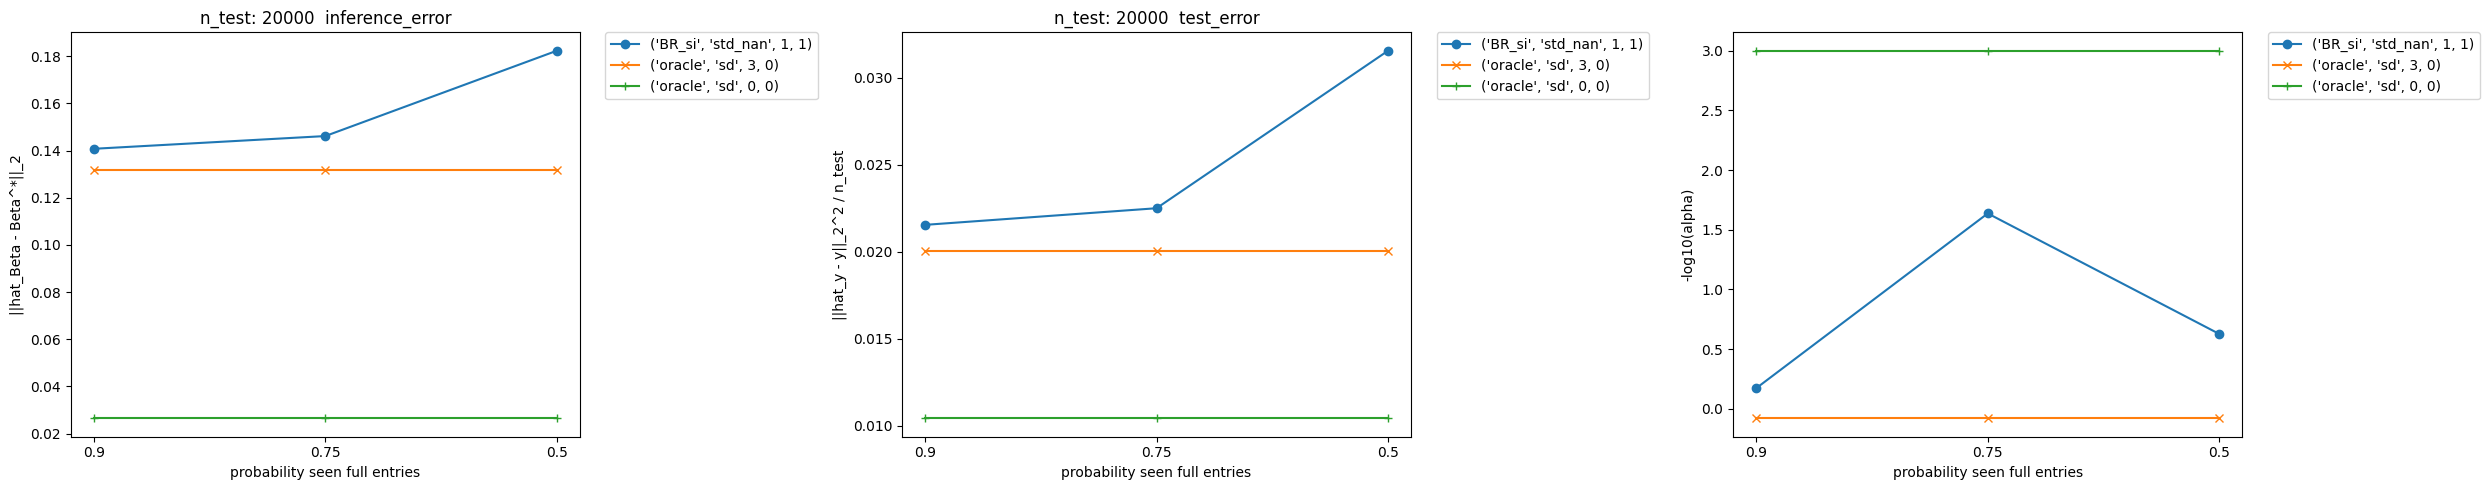

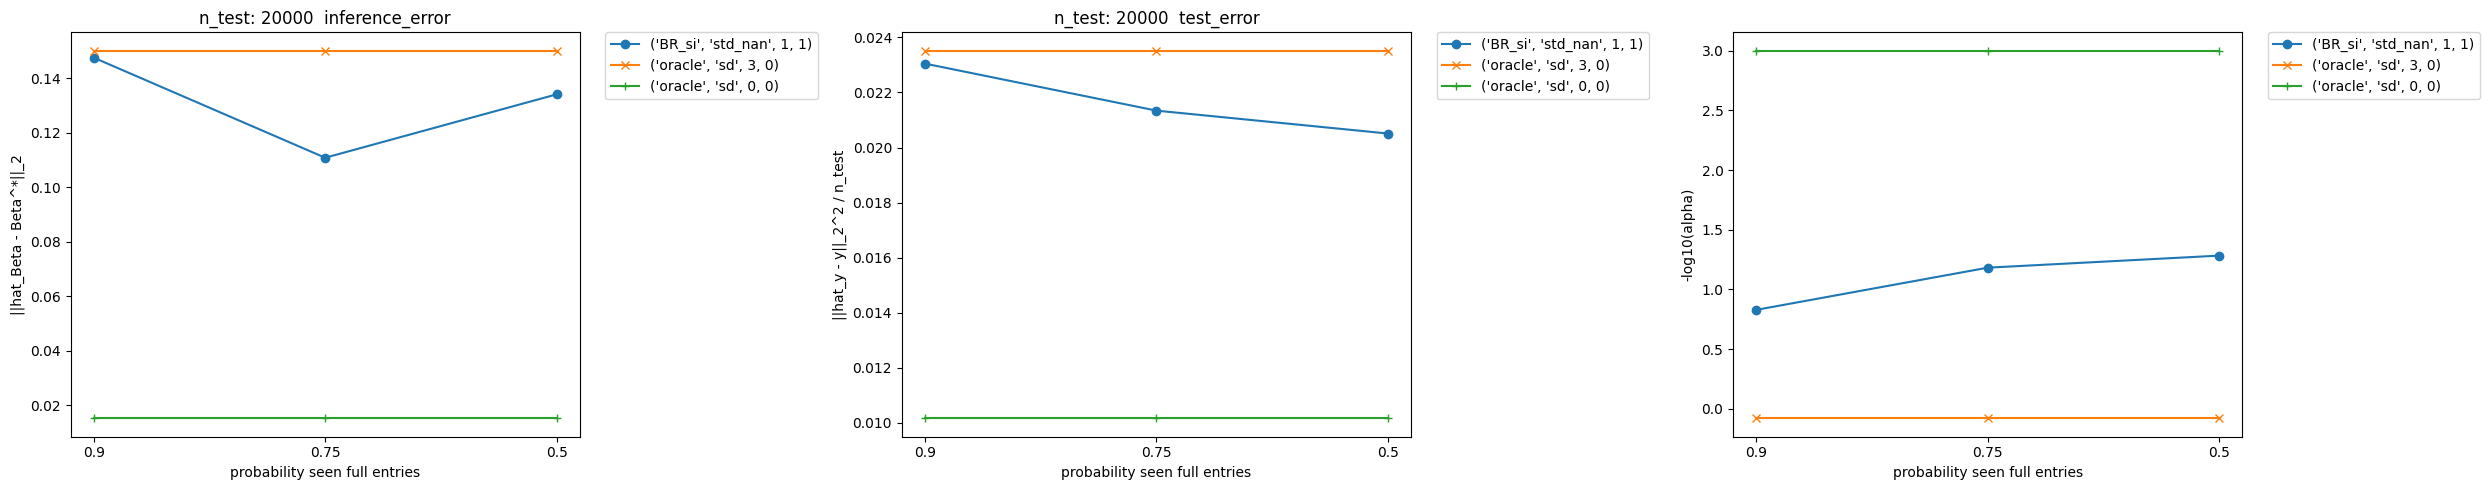

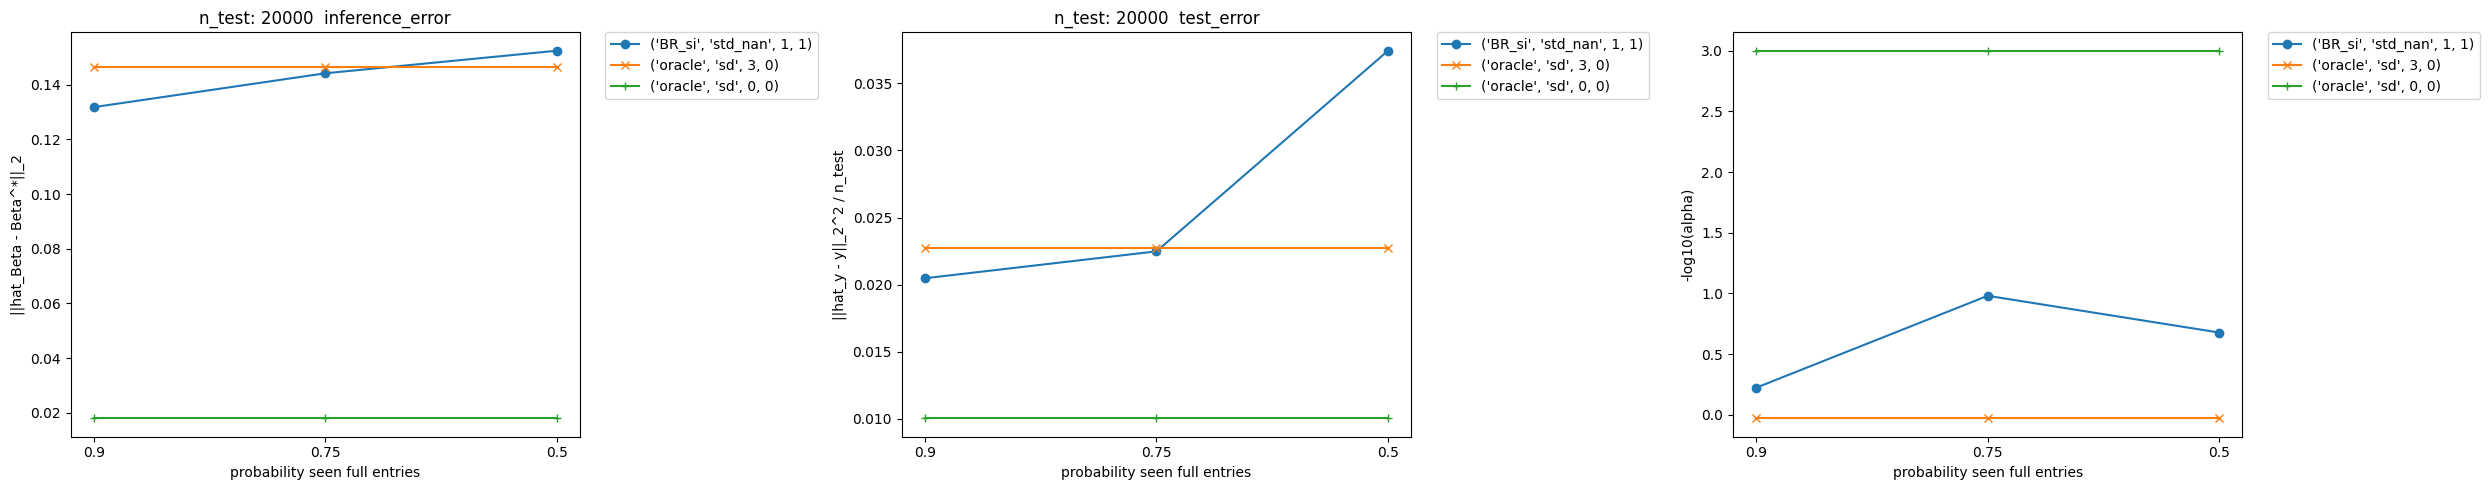

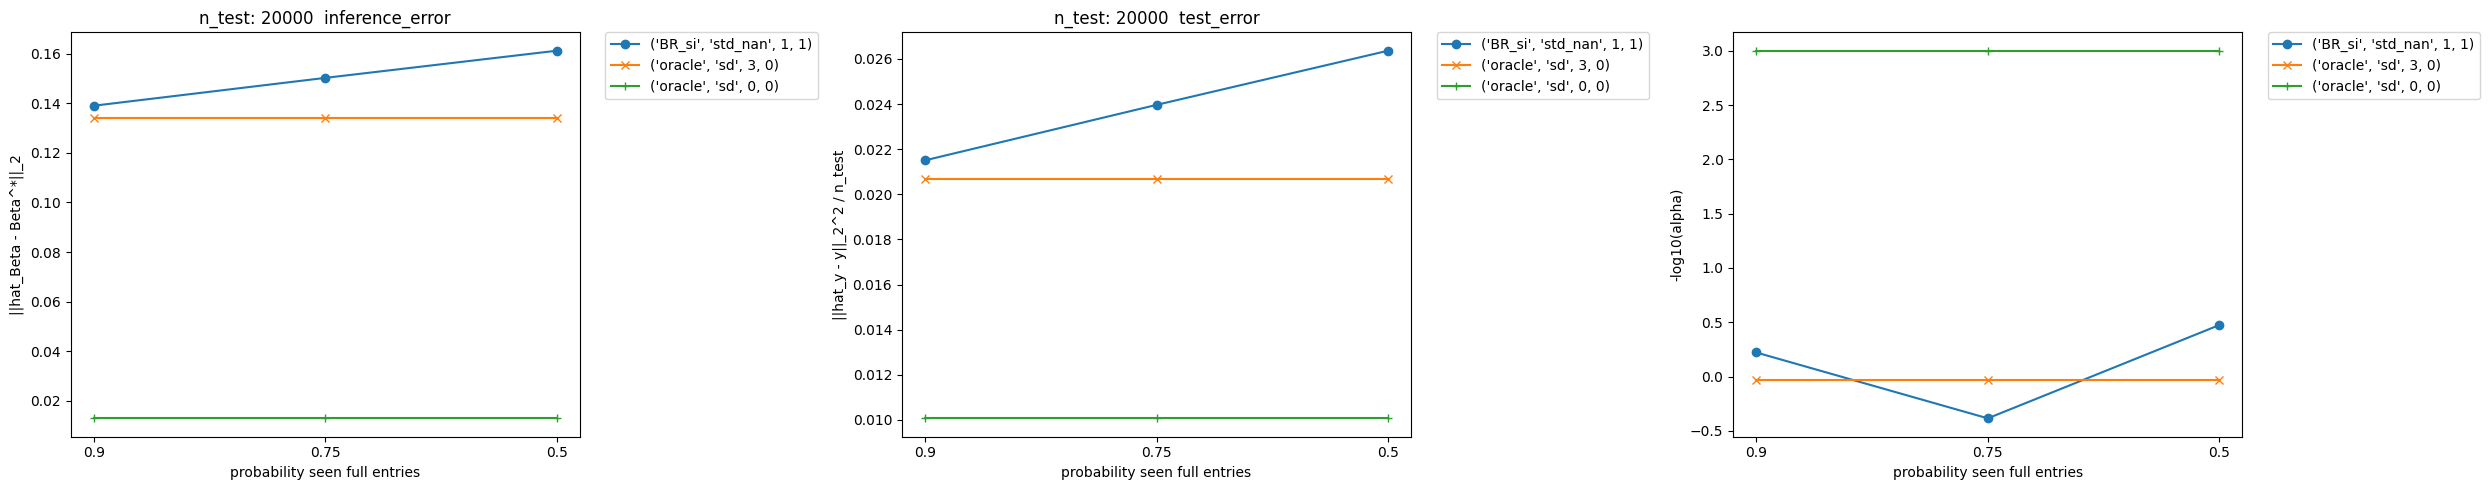

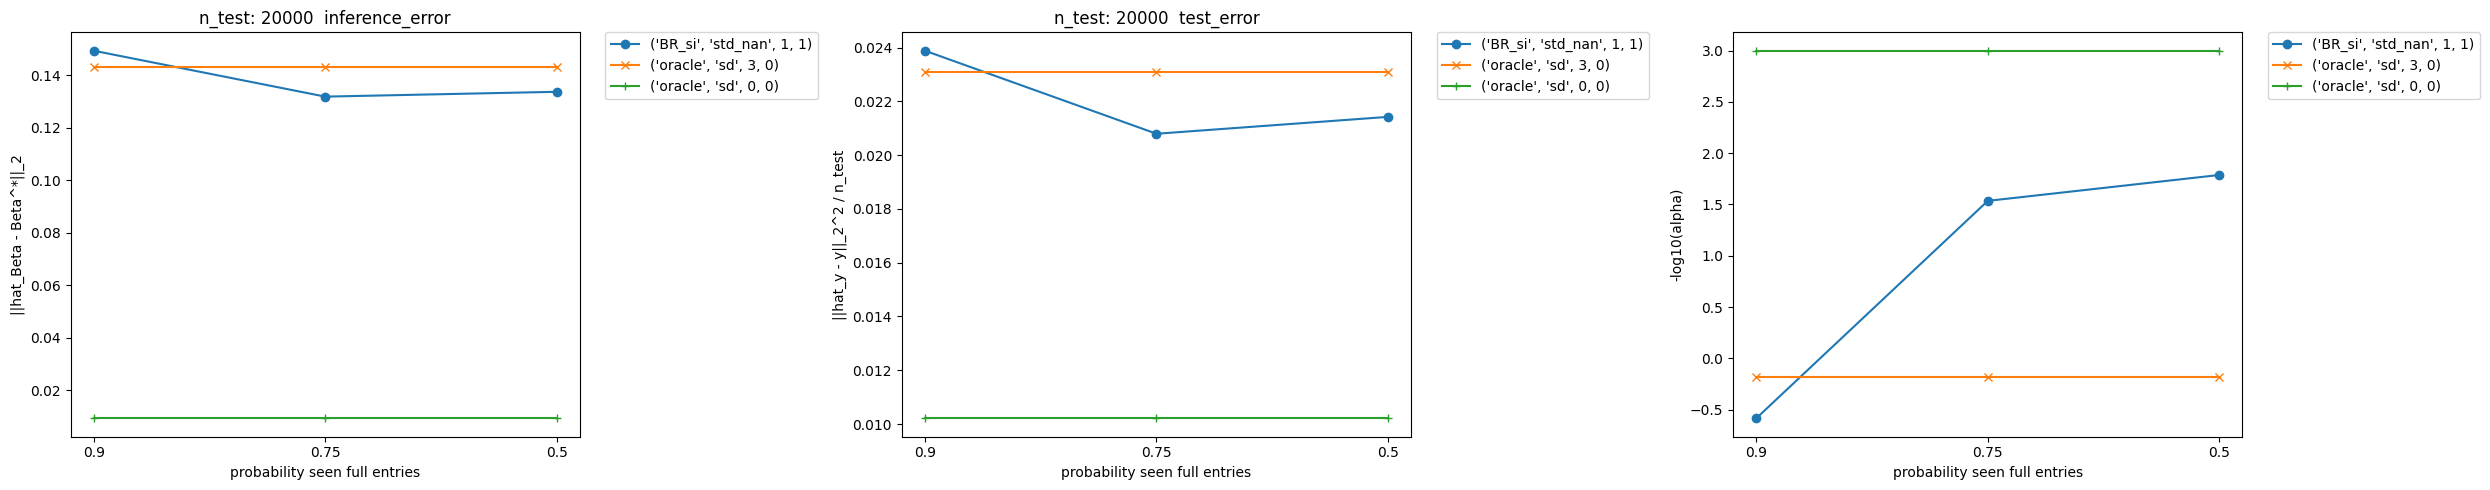

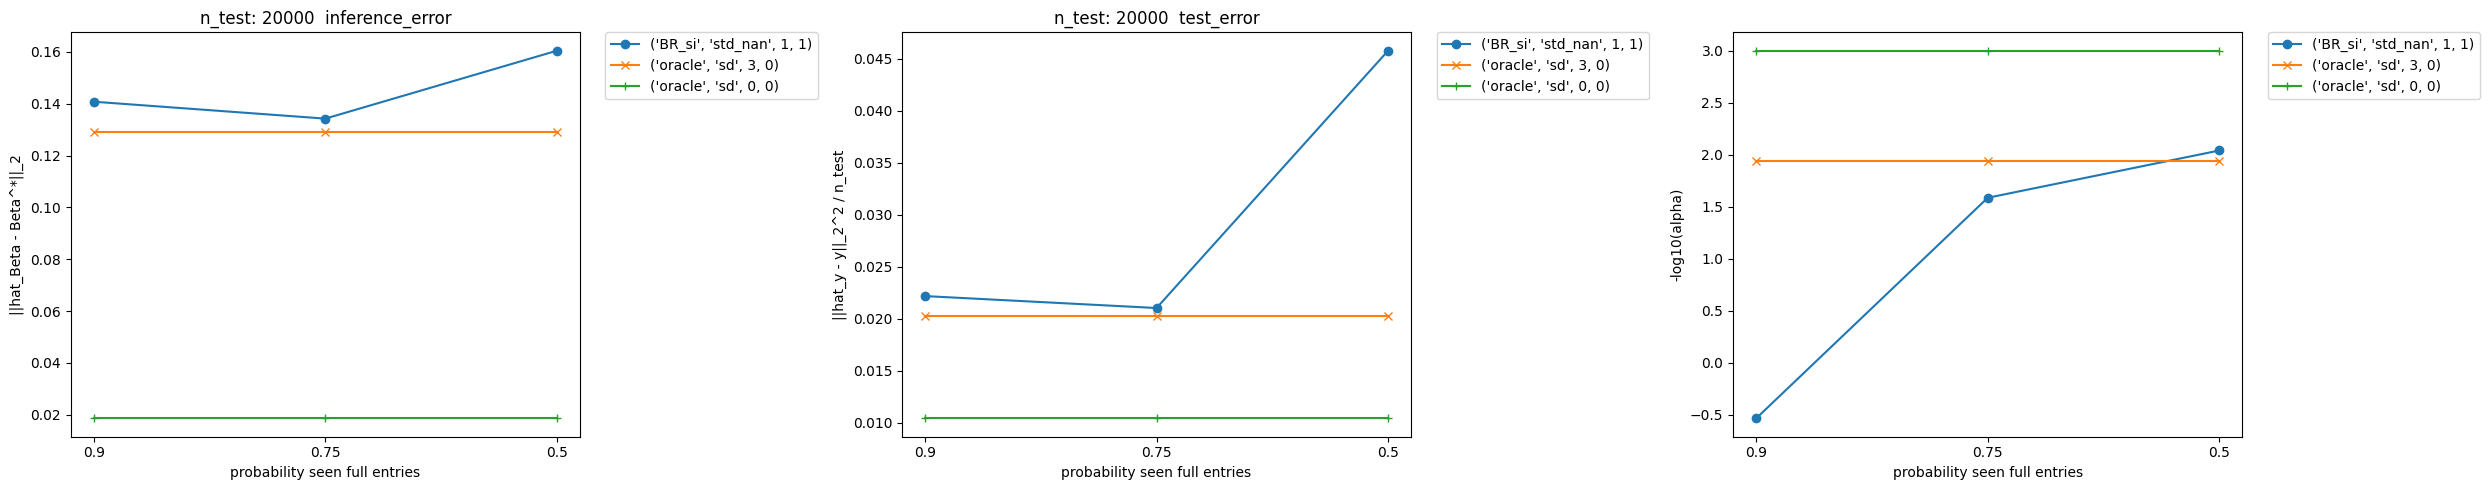

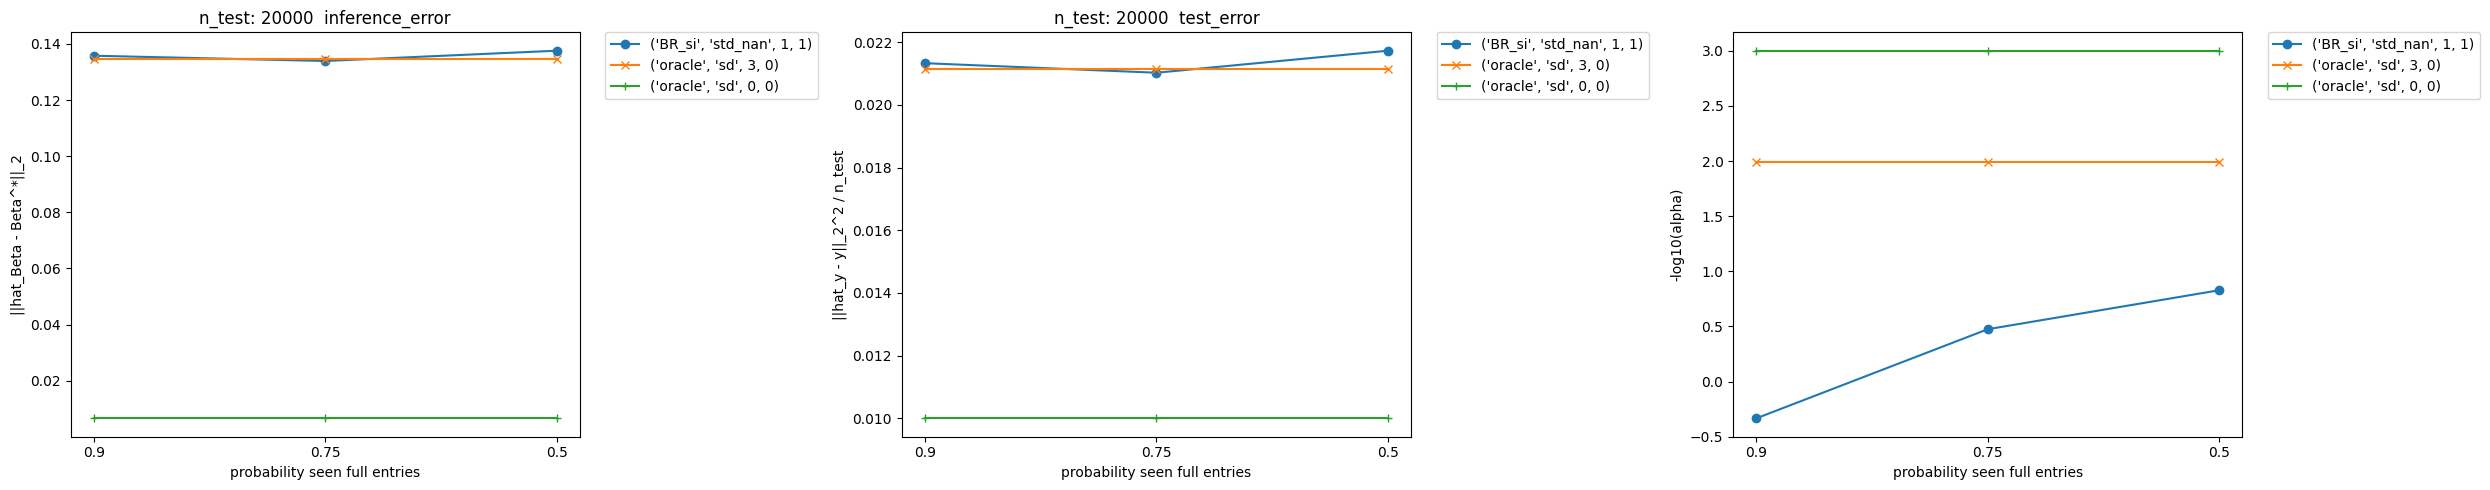

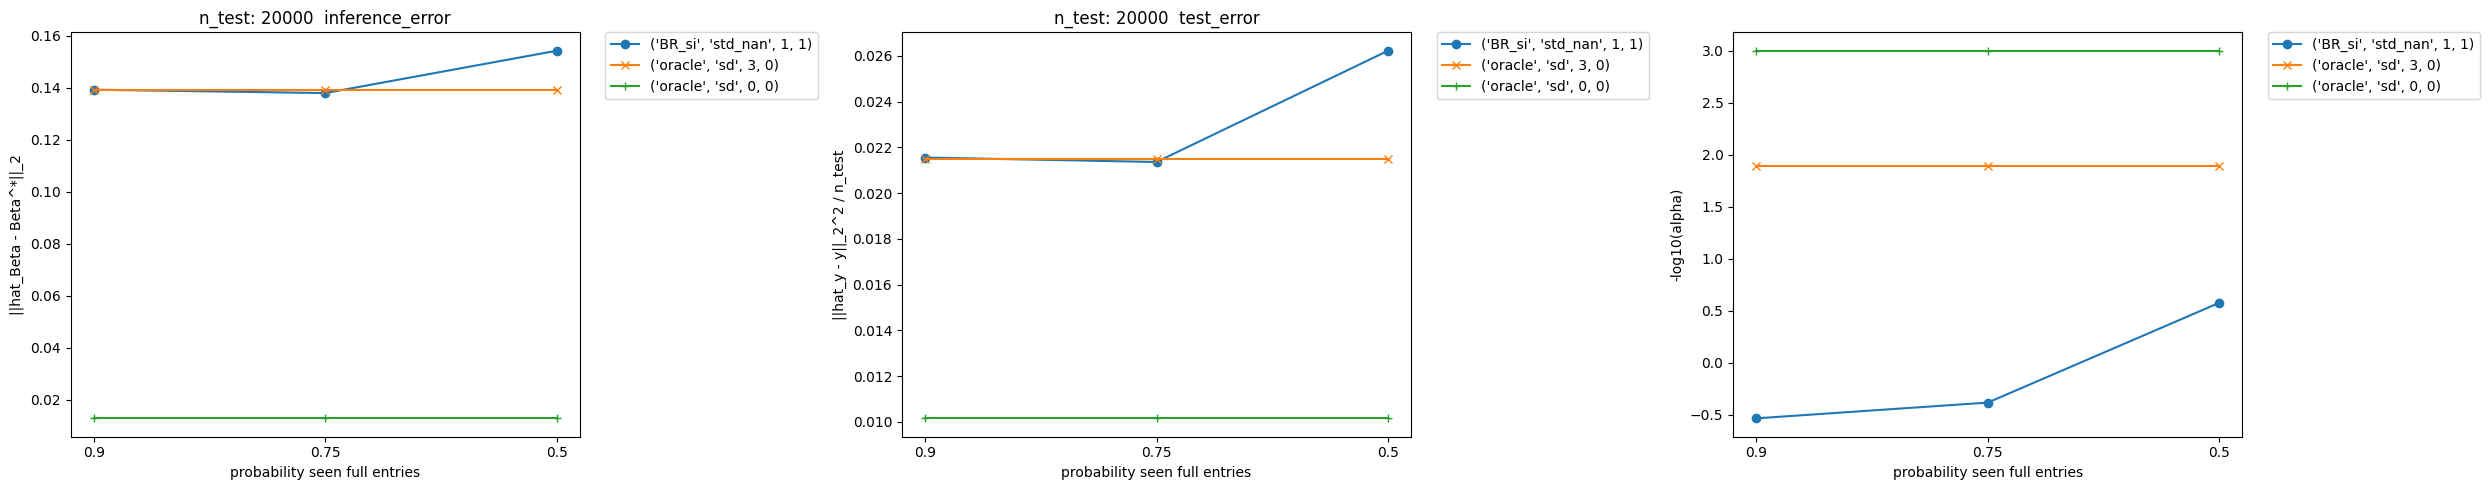

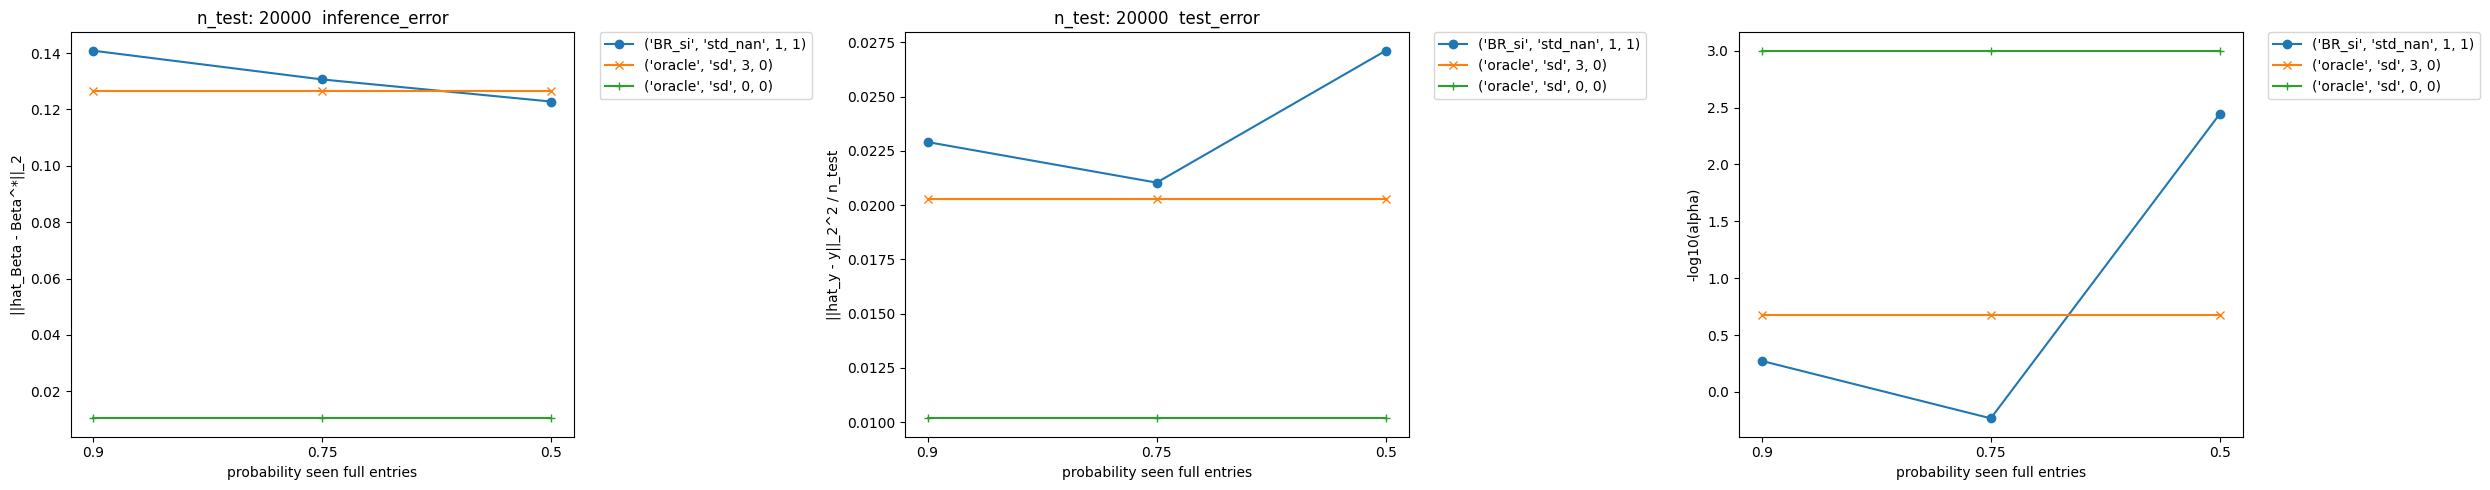

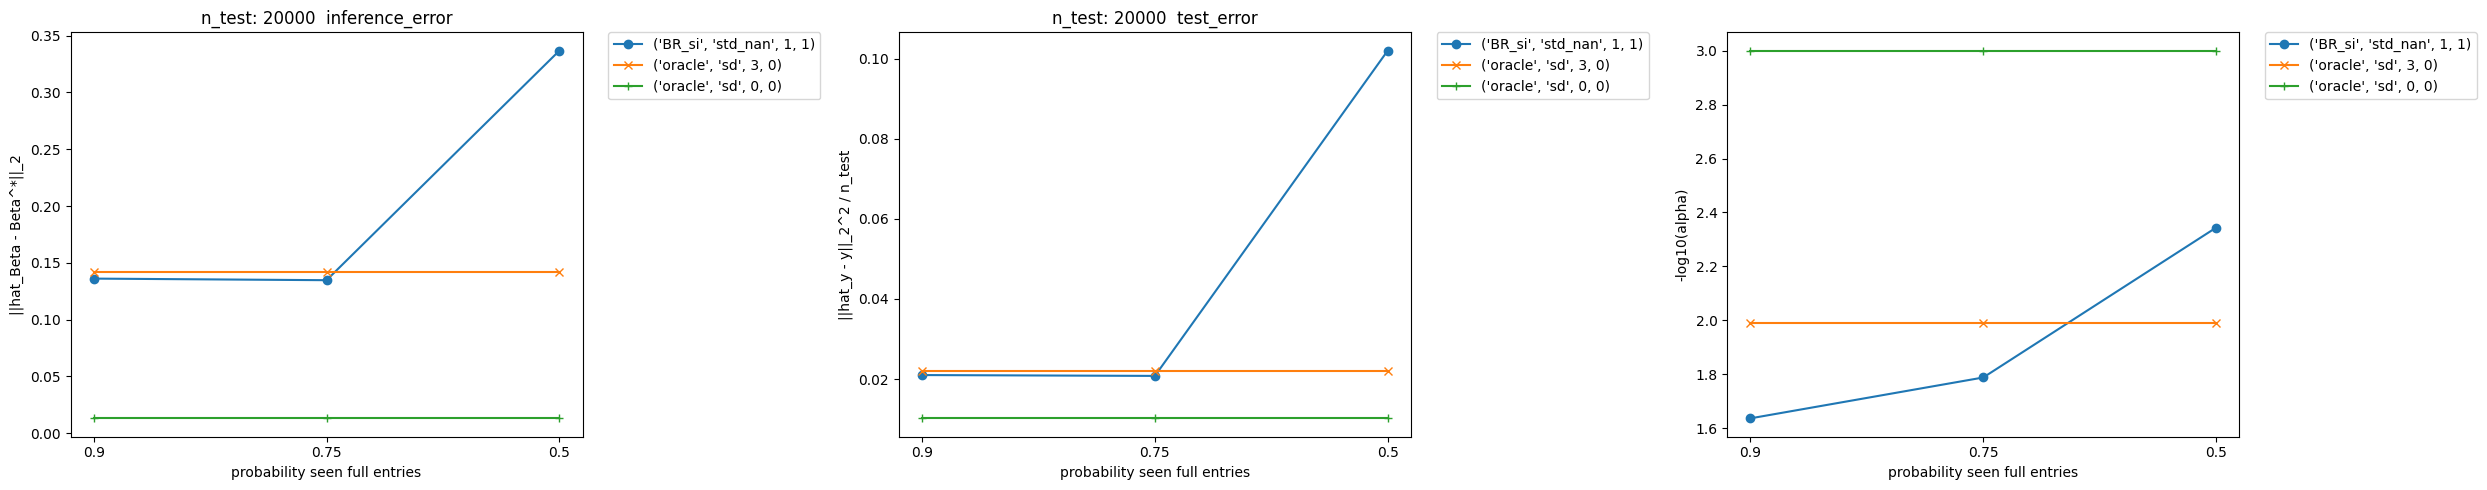

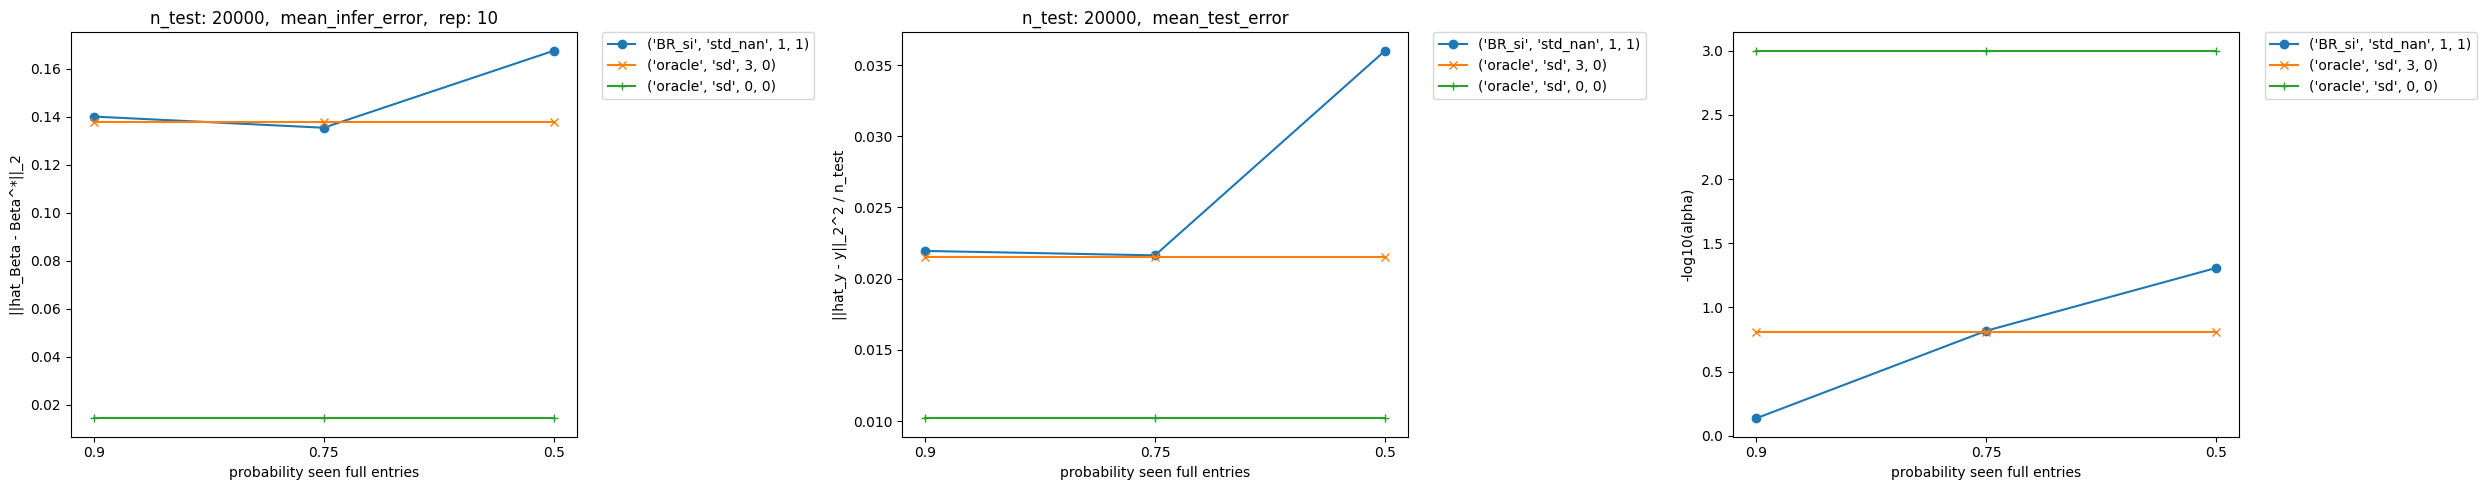

In [94]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [0.9, 0.75, 0.5]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [100] * length_vec
error_vec =  [0.1] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0.4], [0.4, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation':gen, 'title_infer_error':'  inference_error', 'title_test_error':'  test_error'}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing':1},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
nbr_exp = 10
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = ',  mean_infer_error,  rep: ' + str(nbr_exp)
dicc['title_test_error'] = ',  mean_test_error'
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)




## you can see if you manage to take the index i that maximize alpha



In [ ]:
'''
np.random.seed(456789)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, -0.1], [-0.1, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)
dicc = dicc | {'generation':gen}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 30
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



## you can see if you manage to take the index i that maximize alpha
'''


In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [55]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



[[1. 1. 1. 1.]
 [2. 1. 2. 2.]
 [1. 2. 1. 2.]
 [2. 1. 1. 2.]]
[[0 0 0 0]
 [0 0 1 1]
 [0 1 1 0]
 [0 1 0 0]]
[[ 1.  1.  1.  1.]
 [ 2.  1. nan nan]
 [ 1. nan nan  2.]
 [ 2. nan  1.  2.]]
[[2. 2. 1. 1.]
 [1. 2. 2. 1.]]
[[0 1 0 1]
 [1 1 1 1]]
[[ 2. nan  1. nan]
 [nan nan nan nan]]
[[2.         0.99736179 1.         1.49258256]
 [2.26222302 0.99546389 1.00016711 2.14466652]]
[[2.         1.00038291 1.         1.67369936]
 [1.95650492 1.00433389 0.9978242  1.08394832]]
new
[[[]], [[]]]


[]